In [6]:
# Parquet files to analyze
filenames = [
    "digestibility_custom2",
    "digestibility_custom3",
    "digestibility_custom5",
    "digestibility_0_8",
    "hardness_custom2",
    "hardness_custom4",
    "hardness_0_8",
    "tannin_custom2",
    "tannin_custom3",
    "tannin_0_8"
]

# folders = ["local", "_denis", "_wsl"]

# for file in filenames:
#     input_files = [
#         f"workspace/{folders[0]}/{file}.meta.parquet",
#         f"workspace/{folders[1]}/{file}.meta.parquet",
#         f"workspace/{folders[2]}/{file}.meta.parquet"
#     ]
#     output_file = f"{file}.meta.parquet"
#     Predictions.merge_parquet_files(
#         input_files=input_files,
#         output_file=f"workspace/{output_file}",
#         deduplicate=True  # Remove duplicate prediction IDs (default)
#     )

WORKSPACE_PATH = "workspace"

In [7]:
from pathlib import Path
import matplotlib.pyplot as plt
import os

from nirs4all.data.predictions import Predictions
from nirs4all.visualization.predictions import PredictionAnalyzer

In [ ]:
def analyze_predictions_file(predictions_path: str):
    """Analyze a single predictions parquet file with all visualizations."""

    # Check if file exists
    if not Path(predictions_path).exists():
        print(f"⚠️  File not found: {predictions_path}")
        return None

    # Load predictions
    predictions = Predictions()
    predictions.load_from_file(predictions_path)

    file_name = Path(predictions_path).stem.replace('.meta', '')
    print(f"\n{'='*80}")
    print(f"📊 Analyzing: {file_name}")
    print(f"{'='*80}")

    # =========================================================================
    # SYNTHETIC DATAVIZ: Summary statistics
    # =========================================================================
    print(f"\n📈 Summary Statistics:")
    print(f"   • Number of predictions: {len(predictions)}")
    print(f"   • Models: {len(predictions.get_models())} unique ({', '.join(predictions.get_models()[:5])}{'...' if len(predictions.get_models()) > 5 else ''})")
    print(f"   • Datasets: {predictions.get_datasets()}")
    print(f"   • Partitions: {predictions.get_partitions()}")
    print(f"   • Configs: {len(predictions.get_configs())} unique")
    print(f"   • Folds: {predictions.get_folds()}")

    # Determine task type
    sample_preds = predictions.filter_predictions(partition='test', load_arrays=False)
    if sample_preds:
        task_type = sample_preds[0].get('task_type', 'regression')
        is_classification = 'classif' in task_type.lower()
    else:
        task_type = 'regression'
        is_classification = False

    print(f"   • Task type: {task_type}")

    # Select metrics based on task type
    if is_classification:
        rank_metric = 'balanced_accuracy'
        display_metrics = ['accuracy', 'balanced_accuracy', 'f1']
    else:
        rank_metric = 'rmse'
        display_metrics = ['rmse', 'r2', 'mae']

    # =========================================================================
    # TOP MODELS
    # =========================================================================
    print(f"\n🏆 Top 5 models by {rank_metric} (val):")
    top_models = predictions.top(n=5, rank_metric=rank_metric, rank_partition='val')
    for idx, model in enumerate(top_models, 1):
        summary = Predictions.pred_short_string(model, metrics=display_metrics, partition=['val', 'test'])
        print(f"   {idx}. {summary}")

    print(f"\n🏆 Top 5 models by {rank_metric} (val) - Agg reps:")
    top_models = predictions.top(n=5, rank_metric=rank_metric, rank_partition='val', aggregate="ID")
    for idx, model in enumerate(top_models, 1):
        summary = Predictions.pred_short_string(model, metrics=display_metrics, partition=['val', 'test'])
        print(f"   {idx}. {summary}")

    # =========================================================================
    # VISUALIZATIONS
    # =========================================================================
    analyzer = PredictionAnalyzer(predictions, output_dir=None)

    # --- Classification: Top 6 Confusion Matrices (val and test) ---
    if is_classification:
        print(f"\n📊 Confusion Matrices (Top 6 by {rank_metric}):")

        # Confusion matrices ranked by val, displayed on val
        fig_cm_val = analyzer.plot_confusion_matrix(
            k=6,
            rank_metric='balanced_accuracy',
            rank_partition='test',
            display_partition='test',
            aggregate="ID" if sample_preds and 'ID' in sample_preds[0].get('metadata', {}) else None
        )
        plt.suptitle(f"{file_name} - Confusion Matrices (ranked by test, display test) - Agg reps", y=1.02)
        plt.show()

        # Confusion matrices ranked by val, displayed on test
        fig_cm_test = analyzer.plot_confusion_matrix(
            k=6,
            rank_metric='balanced_accuracy',
            rank_partition='val',
            display_partition='test',
            display_metric=['balanced_accuracy', 'accuracy'],
            aggregate="ID" if sample_preds and 'ID' in sample_preds[0].get('metadata', {}) else None
        )
        plt.suptitle(f"{file_name} - Confusion Matrices (ranked by val, display test) - Agg reps", y=1.02)
        plt.show()

        # Confusion matrices ranked by val, displayed on val
        fig_cm_val = analyzer.plot_confusion_matrix(
            k=6,
            rank_metric='balanced_accuracy',
            rank_partition='test',
            display_partition='test',
        )
        plt.suptitle(f"{file_name} - Confusion Matrices (ranked by test, display test)", y=1.02)
        plt.show()

        # Confusion matrices ranked by val, displayed on test
        fig_cm_test = analyzer.plot_confusion_matrix(
            k=6,
            rank_metric='balanced_accuracy',
            rank_partition='val',
            display_partition='test',
            display_metric=['balanced_accuracy', 'accuracy'],
        )
        plt.suptitle(f"{file_name} - Confusion Matrices (ranked by val, display test)", y=1.02)
        plt.show()

    # --- Regression: Top 3 ---
    else:
        print(f"\n📊 Top 3 Model Comparison:")
        fig_top3 = analyzer.plot_top_k(
            k=3,
            rank_metric='rmse',
            rank_partition='val',
            aggregate="ID"
        )
        plt.suptitle(f"{file_name} - Top 3 Models (ranked by val) - Agg reps", y=1.02)
        plt.show()

        print(f"\n📊 Top 3 Model Comparison:")
        fig_top3 = analyzer.plot_top_k(
            k=3,
            rank_metric='rmse',
            rank_partition='val',
        )
        plt.suptitle(f"{file_name} - Top 3 Models (ranked by val)", y=1.02)
        plt.show()

    # --- Heatmap ranked by VAL ---
    print(f"\n🗺️  Heatmap (ranked by val):")
    fig_heatmap_val = analyzer.plot_heatmap(
        x_var="partition",
        y_var="model_name",
        rank_metric=rank_metric,
        display_metric=rank_metric,
        show_counts=False,
        rank_partition='val'
    )
    plt.suptitle(f"{file_name} - Heatmap (ranked by val)", y=1.02)
    plt.show()

    # --- Heatmap ranked by TEST ---
    print(f"\n🗺️  Heatmap (ranked by test):")
    fig_heatmap_test = analyzer.plot_heatmap(
        x_var="partition",
        y_var="model_name",
        rank_metric=rank_metric,
        display_metric=rank_metric,
        show_counts=False,
        rank_partition='test'
    )
    plt.suptitle(f"{file_name} - Heatmap (ranked by test)", y=1.02)
    plt.show()

        # --- Heatmap ranked by VAL ---
    print(f"\n🗺️  Heatmap (ranked by val):")
    fig_heatmap_val = analyzer.plot_heatmap(
        x_var="partition",
        y_var="model_name",
        rank_metric=rank_metric,
        display_metric=rank_metric,
        show_counts=False,
        rank_partition='val',
        aggregate="ID"
    )
    plt.suptitle(f"{file_name} - Heatmap (ranked by val) - Agg reps", y=1.02)
    plt.show()

    # --- Heatmap ranked by TEST ---
    print(f"\n🗺️  Heatmap (ranked by test):")
    fig_heatmap_test = analyzer.plot_heatmap(
        x_var="partition",
        y_var="model_name",
        rank_metric=rank_metric,
        display_metric=rank_metric,
        show_counts=False,
        rank_partition='test',
        aggregate="ID"
    )
    plt.suptitle(f"{file_name} - Heatmap (ranked by test) - Agg reps", y=1.02)
    plt.show()

    # --- Candlestick plot ---
    fig_candlestick = analyzer.plot_candlestick(
        variable="model_name",
        display_metric=rank_metric,
        display_partition='test'
    )
    plt.suptitle(f"{file_name} - Score Distribution by Model", y=1.02)
    plt.show()

    fig_candlestick = analyzer.plot_candlestick(
        variable="model_name",
        display_metric=rank_metric,
        display_partition='test',
        aggregate="ID"
    )
    plt.suptitle(f"{file_name} - Score Distribution by Model - Agg reps", y=1.02)
    plt.show()


    # --- Histogram ---
    fig_histogram = analyzer.plot_histogram(
        display_metric=rank_metric,
        display_partition='test'
    )
    plt.suptitle(f"{file_name} - Score Histogram", y=1.02)
    plt.show()

    fig_histogram = analyzer.plot_histogram(
        display_metric=rank_metric,
        display_partition='test',
        aggregate="ID"
    )
    plt.suptitle(f"{file_name} - Score Histogram - Agg reps", y=1.02)
    plt.show()

    return predictions


 Analyzing: digestibility_custom2

 Summary Statistics:
    Number of predictions: 1227
    Models: 79 unique (PLSDA-16, MLP_256_128_64, PLSDA-9, oplsda_1_14, oplsda_1_5...)
    Datasets: ['digestibility_custom2']
    Partitions: ['test', 'val', 'train']
    Configs: 15 unique
    Folds: ['avg', '1', 'w_avg', '0', '2']
    Task type: binary_classification

 Top 5 models by balanced_accuracy (val):
   1. catboost - balanced_accuracy [test: 0.5133], [val: 0.8452],  [val]: [accuracy:0.8757], [balanced_accuracy:0.5133], [f1:0.8451] [test]: [accuracy:0.8757], [balanced_accuracy:0.5133], [f1:0.8451], (fold: avg, id: 4, step: 27) - [8a55af1fe219aefd]
   2. catboost - balanced_accuracy [test: 0.5125], [val: 0.8122],  [val]: [accuracy:0.8743], [balanced_accuracy:0.5125], [f1:0.8442] [test]: [accuracy:0.8743], [balanced_accuracy:0.5125], [f1:0.8442], (fold: w_avg, id: 5, step: 27) - [cc0e33d9ed32e2a8]
   3. MLP_256_128_64 - balanced_accuracy [test: 0.6010], [val: 0.7752],  [val]: [accuracy:0.72

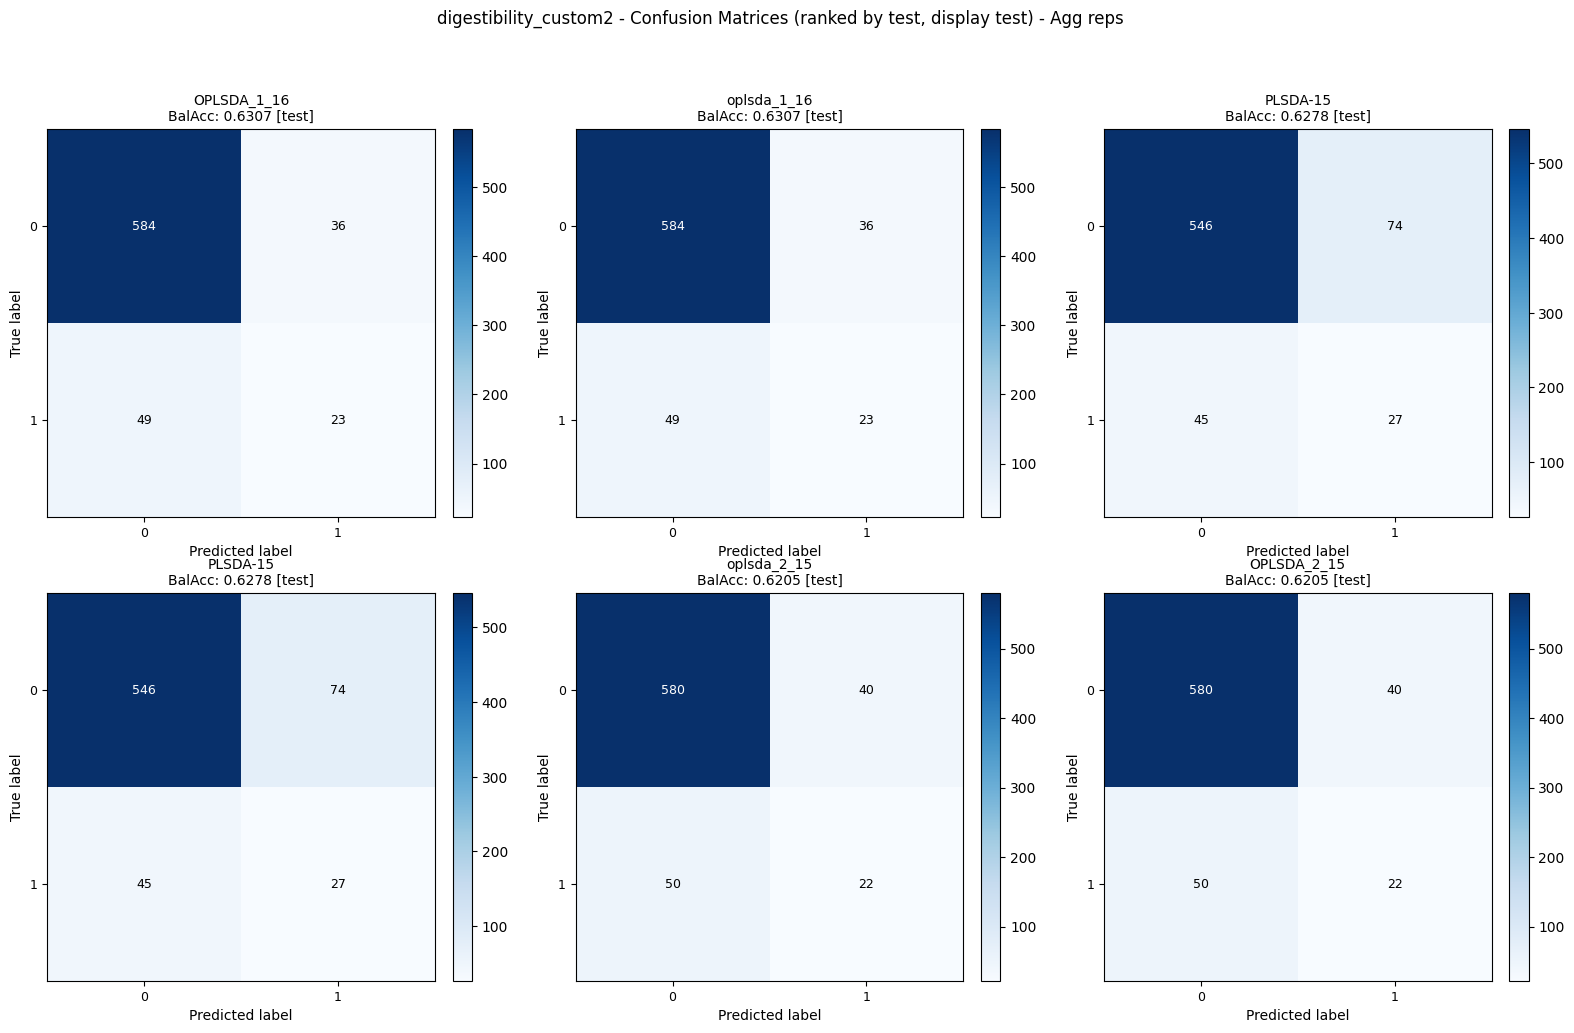

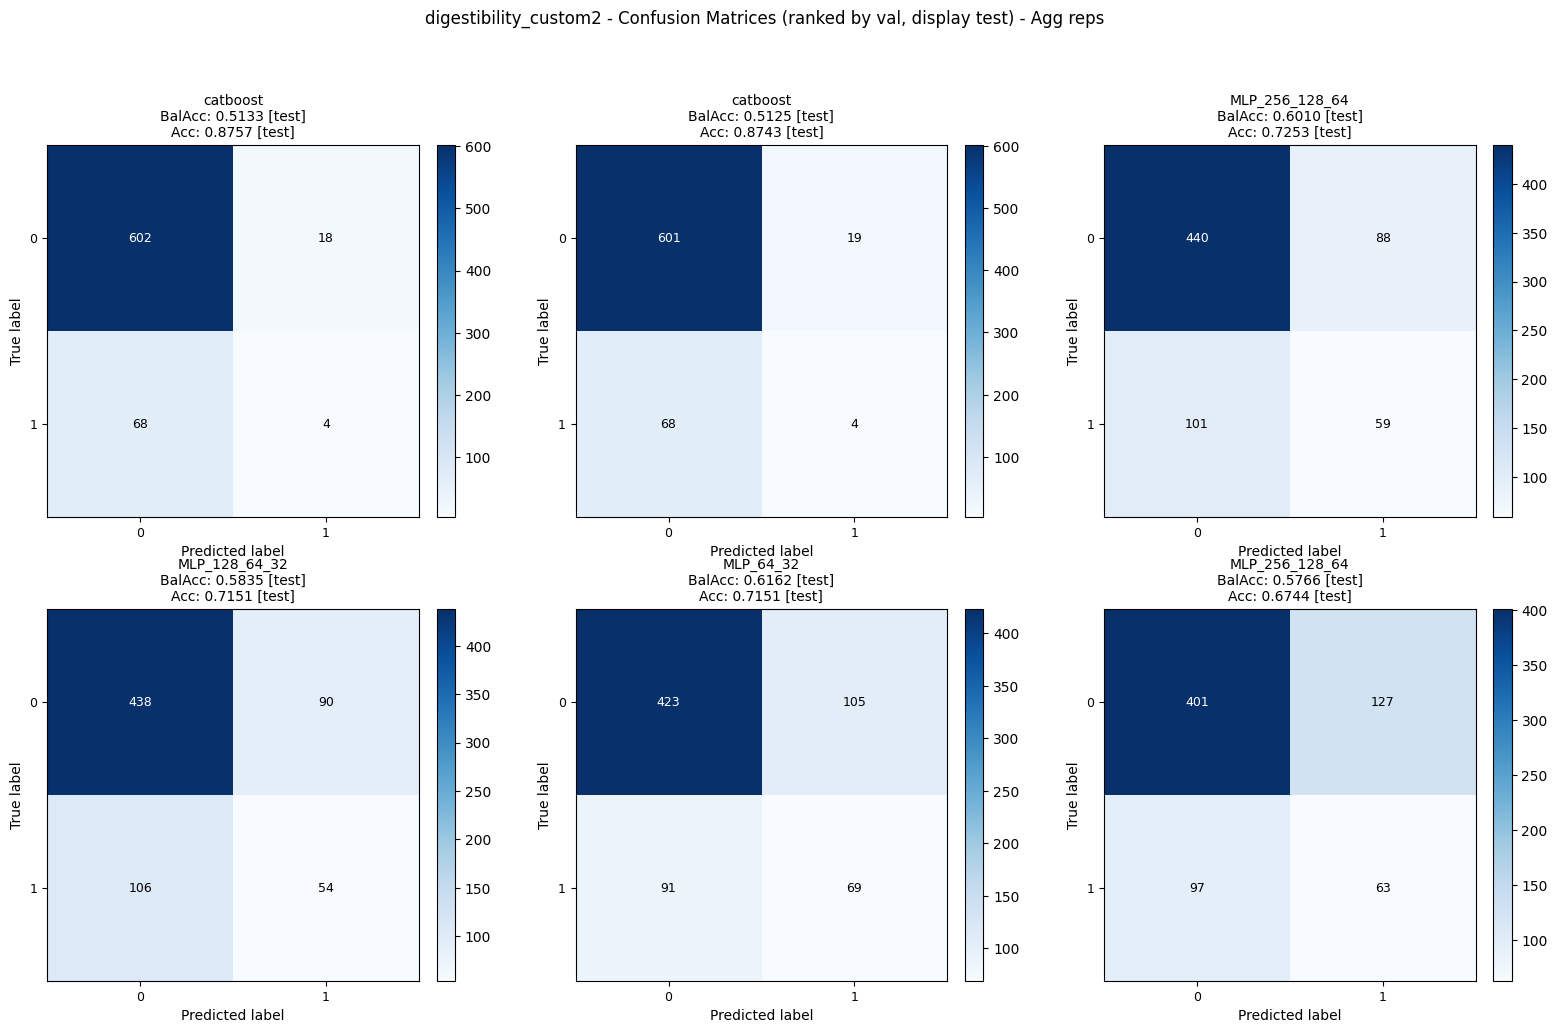

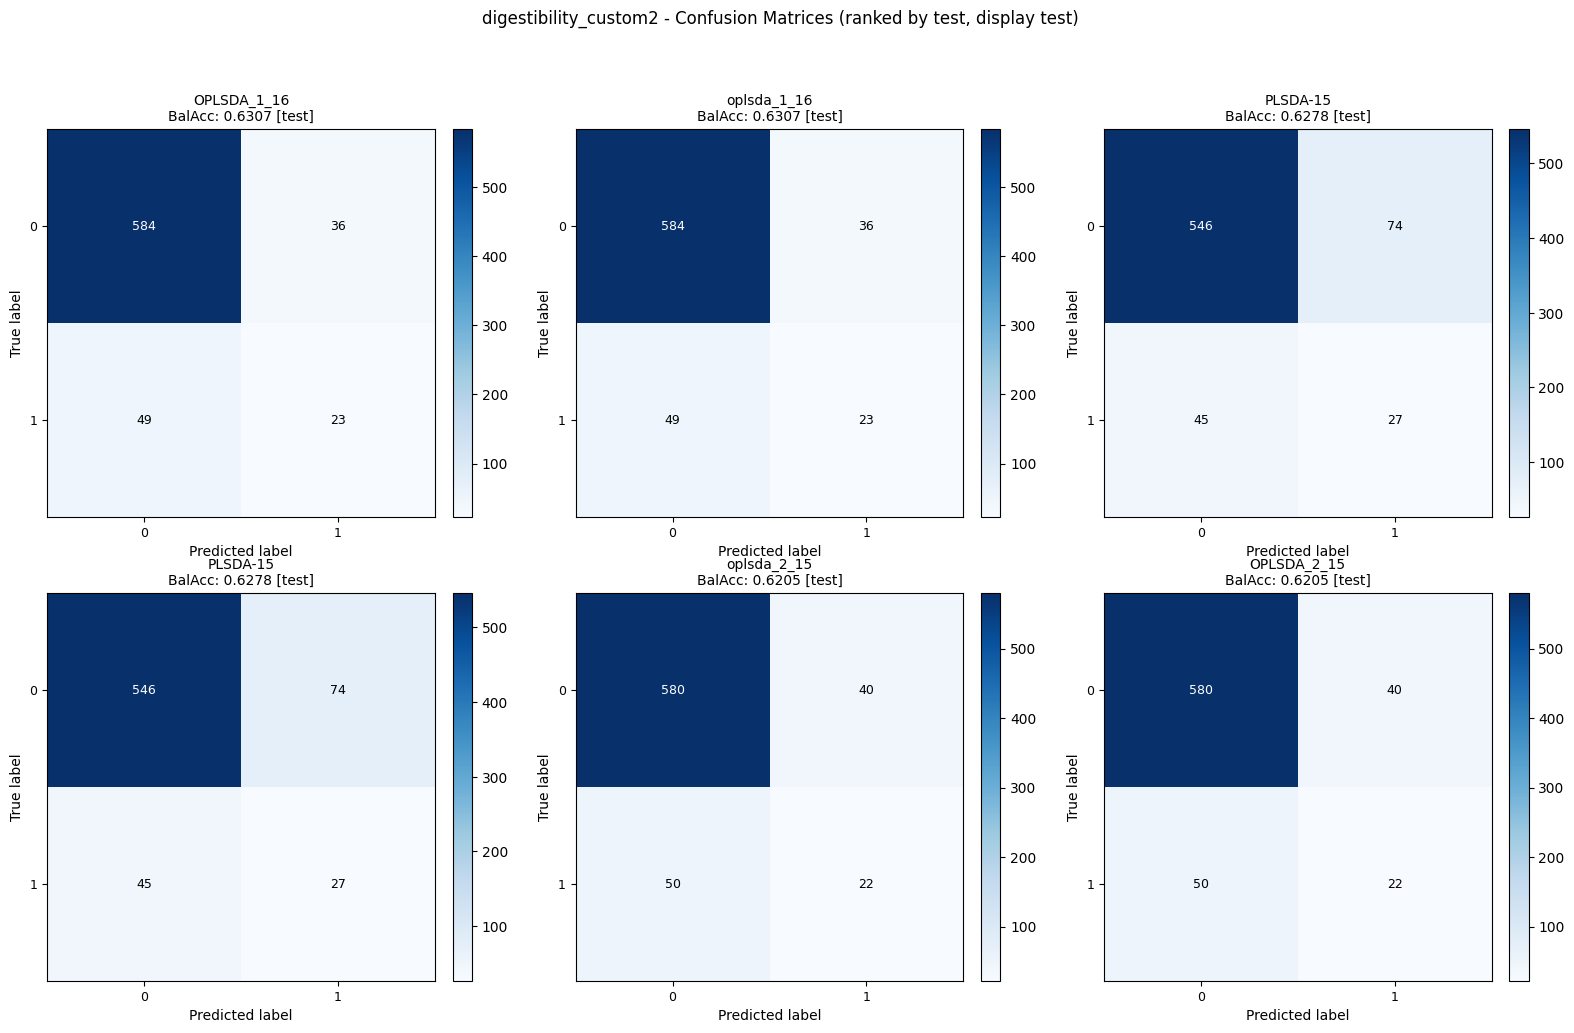

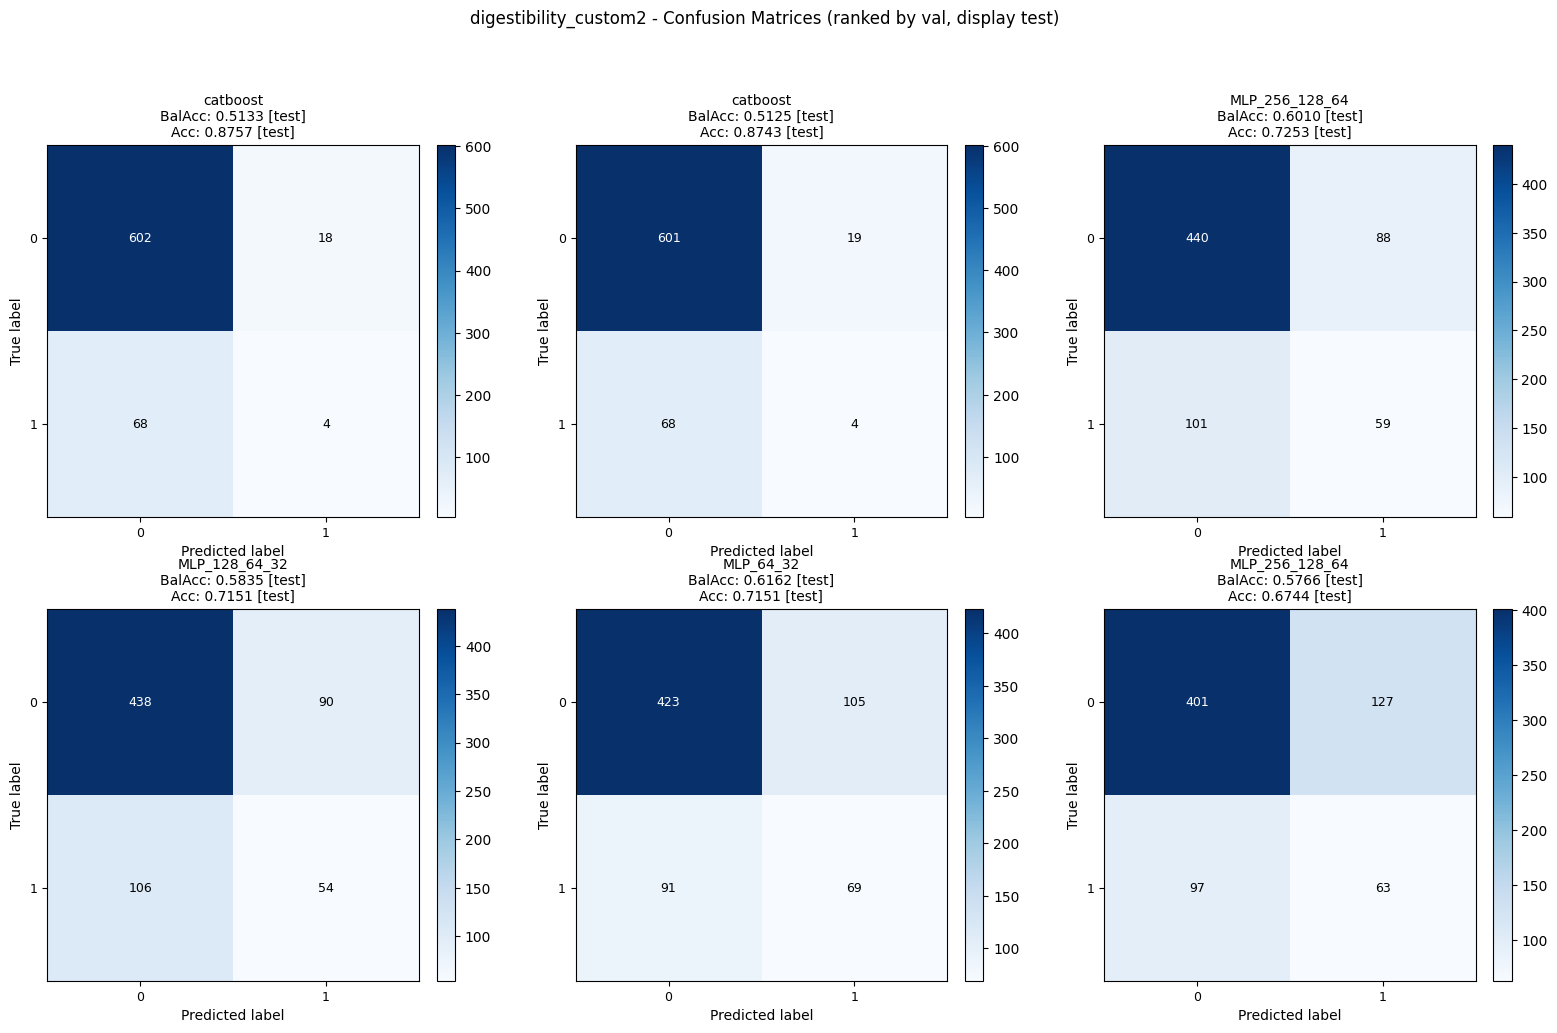


  Heatmap (ranked by val):
Data wrangling time: 0.0130 seconds
Matplotlib render time: 0.1258 seconds


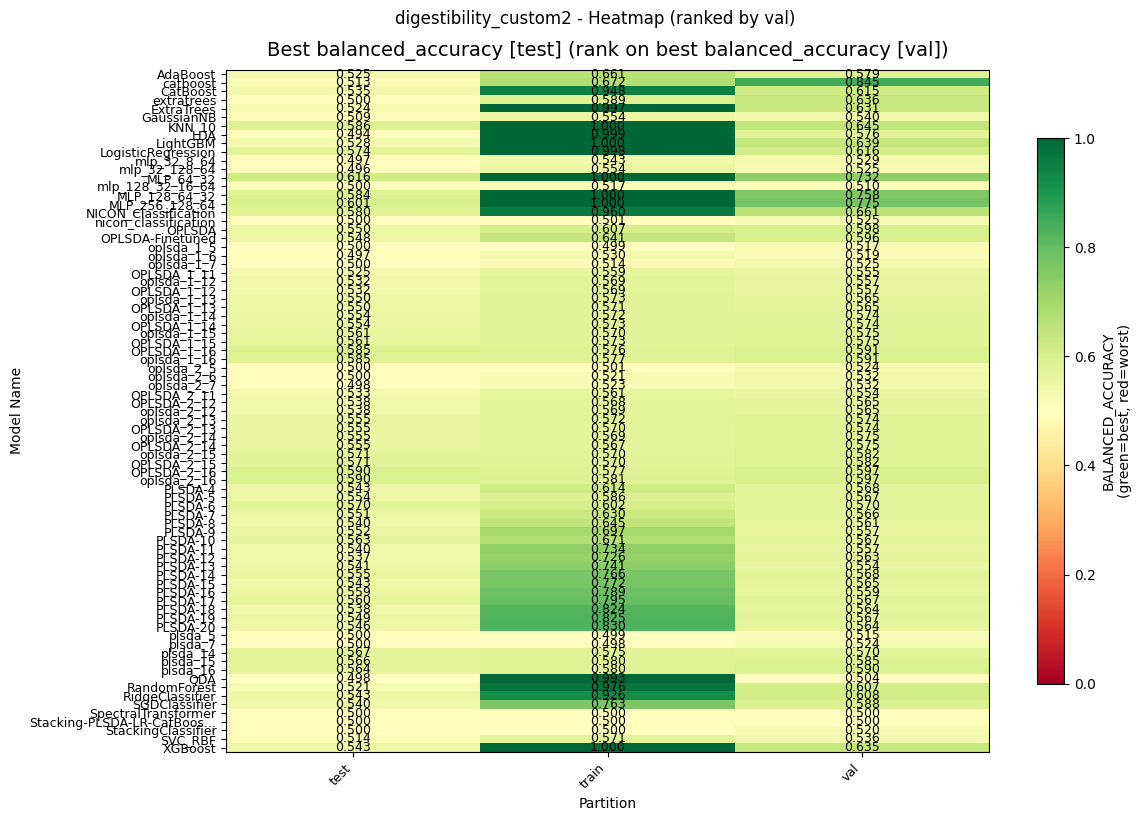


  Heatmap (ranked by test):
Data wrangling time: 0.0005 seconds
Matplotlib render time: 0.1422 seconds


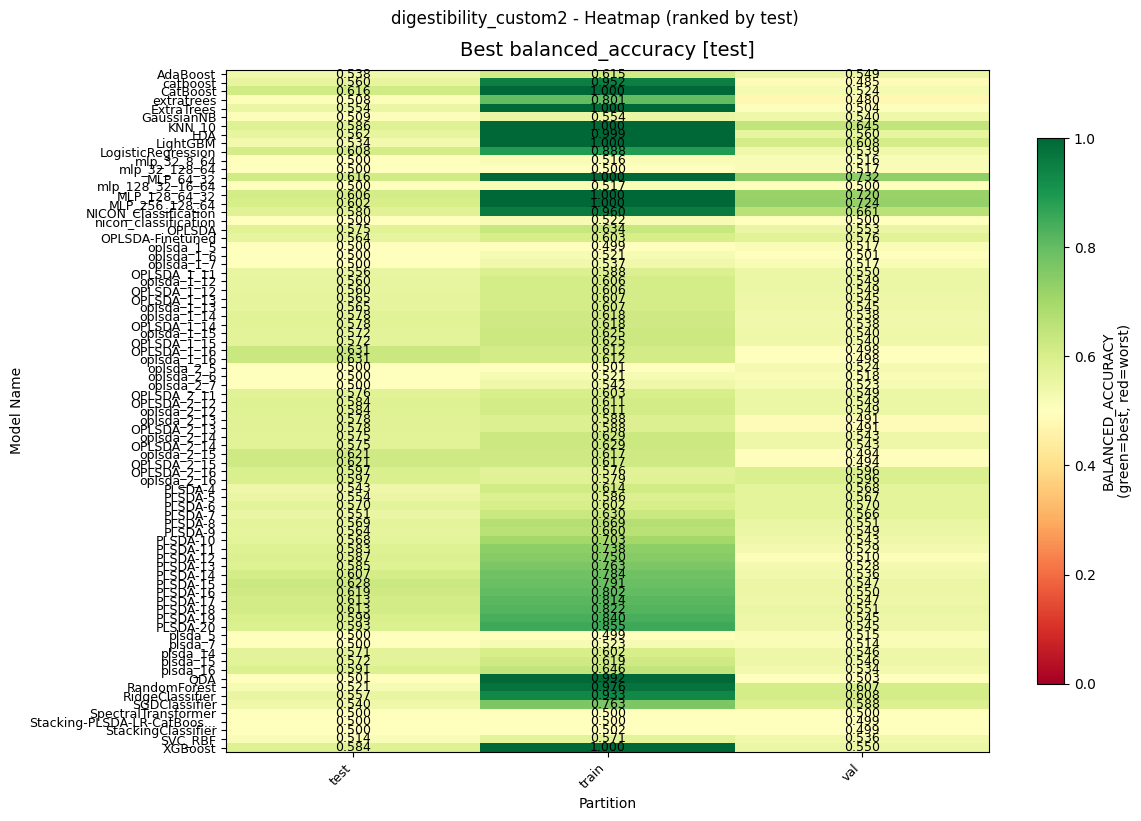


  Heatmap (ranked by val):
Data wrangling time (with aggregation): 5.6080 seconds
Matplotlib render time: 0.0970 seconds


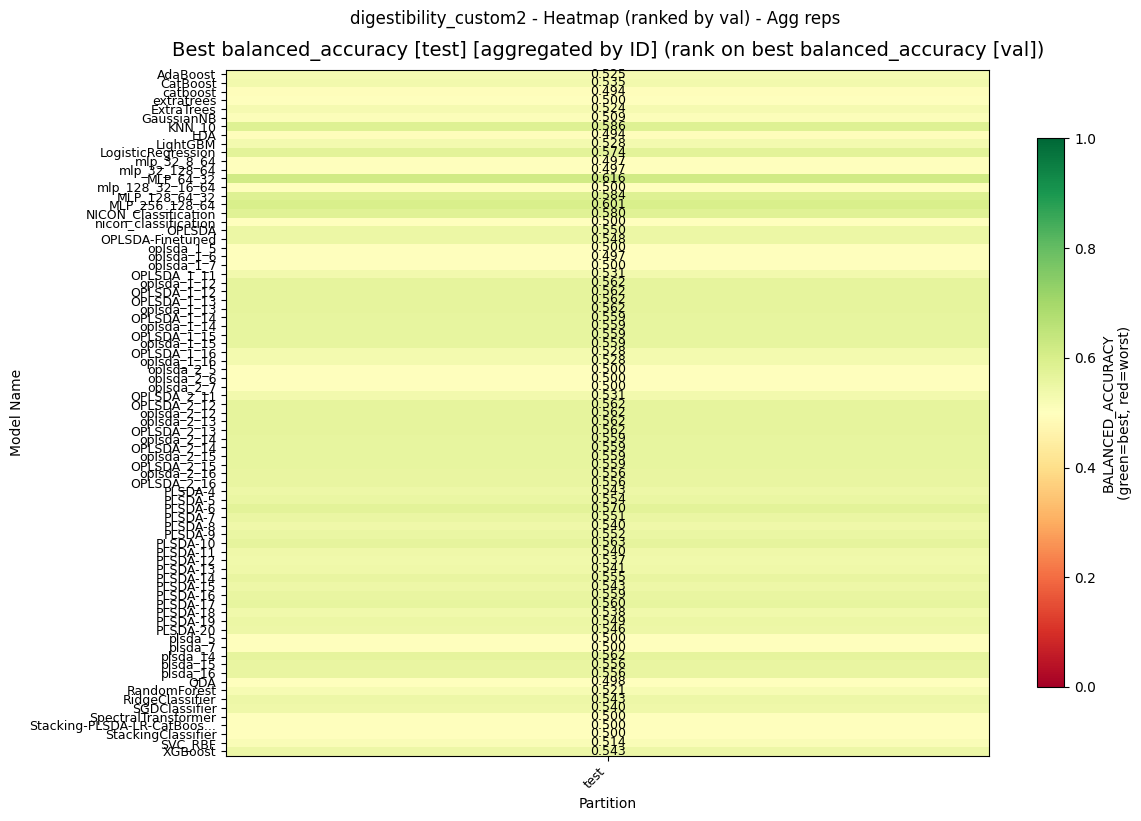


  Heatmap (ranked by test):
Data wrangling time (with aggregation): 5.1917 seconds
Matplotlib render time: 0.2572 seconds


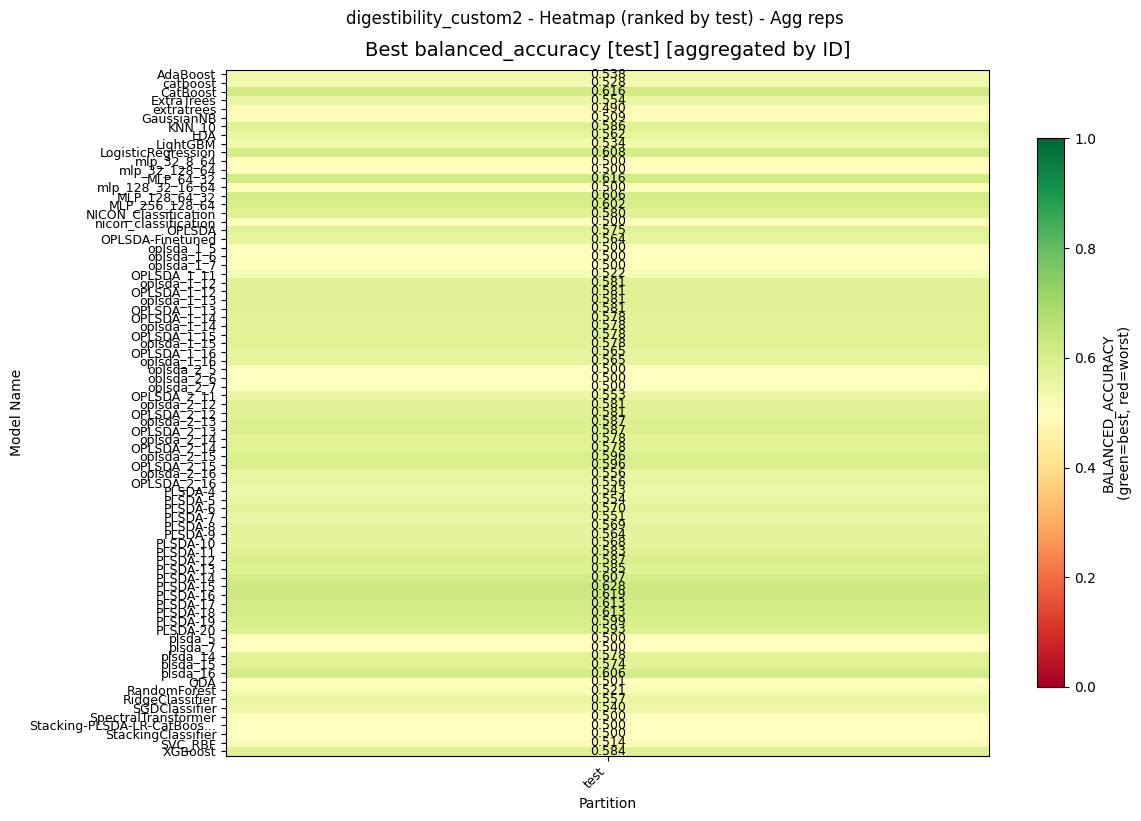

Candlestick data wrangling time: 0.0000 seconds
Matplotlib render time: 0.1594 seconds


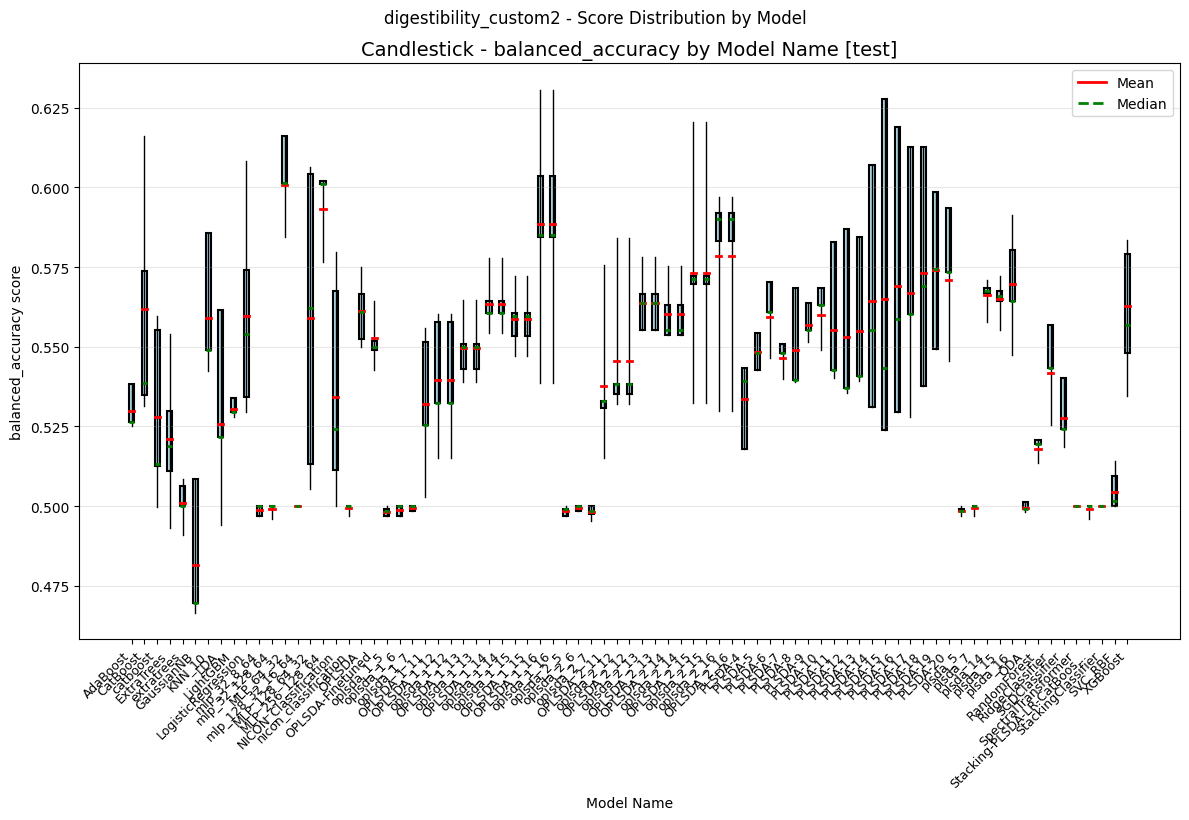

Candlestick data wrangling time: 0.0040 seconds
Matplotlib render time: 0.1552 seconds


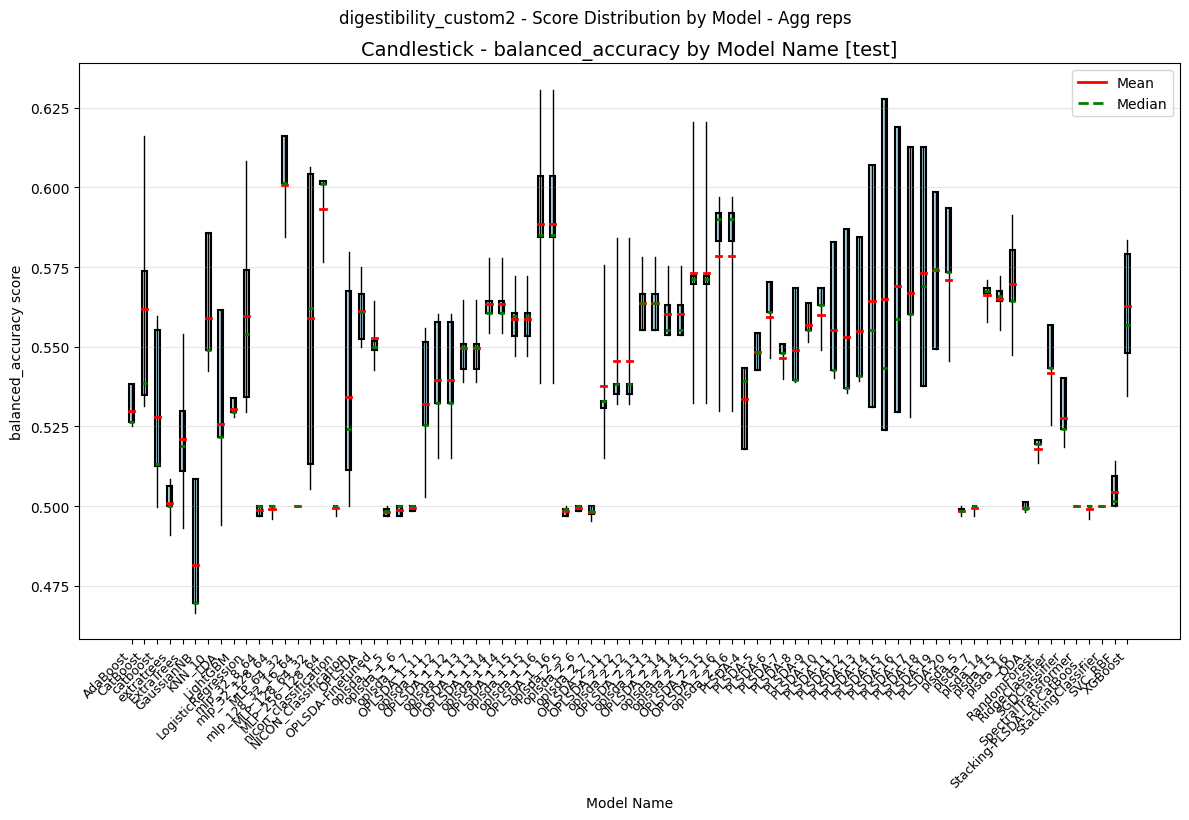

Histogram data wrangling time: 0.0000 seconds
Matplotlib render time: 0.0385 seconds


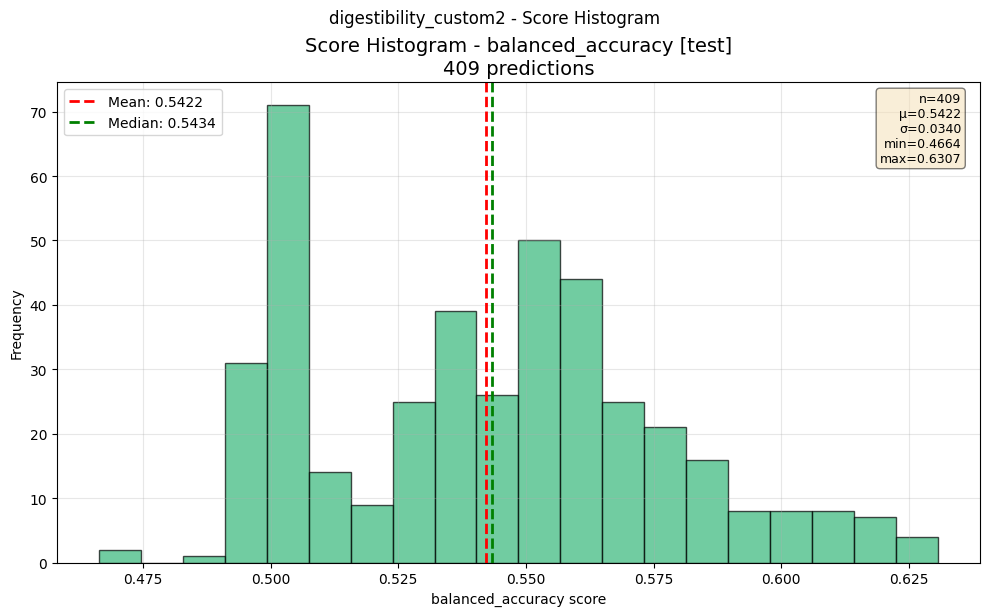

Histogram data wrangling time: 0.0020 seconds
Matplotlib render time: 0.0370 seconds


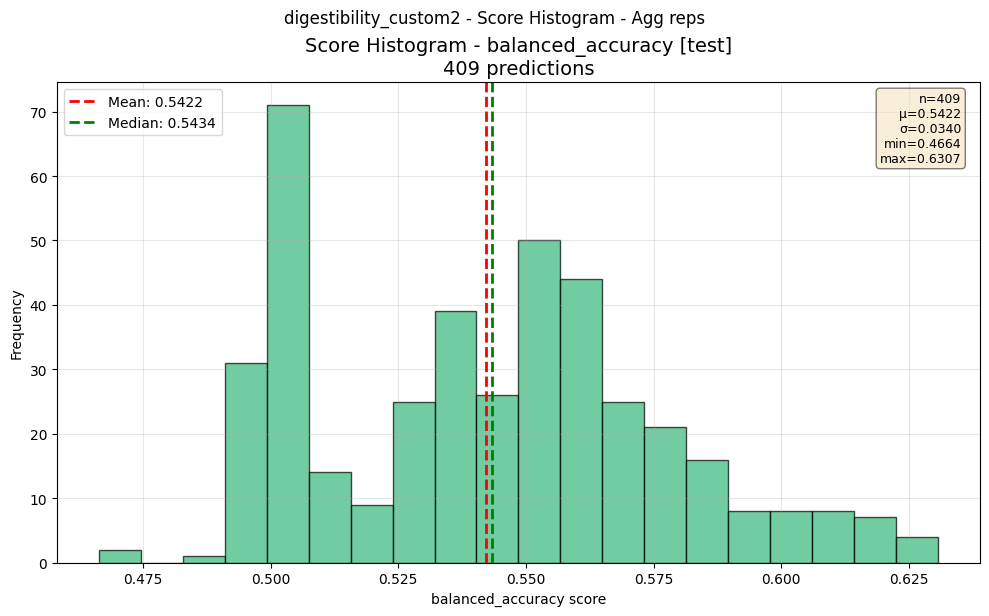


 Analyzing: digestibility_custom3

 Summary Statistics:
    Number of predictions: 1203
    Models: 79 unique (CatBoost, OPLSDA_2_12, Stacking-PLSDA-LR-CatBoost, oplsda_1_12, mlp_32_128_64...)
    Datasets: ['digestibility_custom3']
    Partitions: ['train', 'val', 'test']
    Configs: 14 unique
    Folds: ['0', 'avg', '2', '1', 'w_avg']
    Task type: multiclass_classification

 Top 5 models by balanced_accuracy (val):
   1. MLP_256_128_64 - balanced_accuracy [test: 0.4265], [val: 0.6750],  [val]: [accuracy:0.6222], [balanced_accuracy:0.4265], [f1:0.6138] [test]: [accuracy:0.6222], [balanced_accuracy:0.4265], [f1:0.6138], (fold: 1, id: 2, step: 17) - [2794d25d14201cb5]
   2. extratrees - balanced_accuracy [test: 0.4456], [val: 0.6711],  [val]: [accuracy:0.6986], [balanced_accuracy:0.4456], [f1:0.6893] [test]: [accuracy:0.6986], [balanced_accuracy:0.4456], [f1:0.6893], (fold: avg, id: 4, step: 31) - [283d99c7e6a96071]
   3. MLP_64_32 - balanced_accuracy [test: 0.4293], [val: 0.6683], 

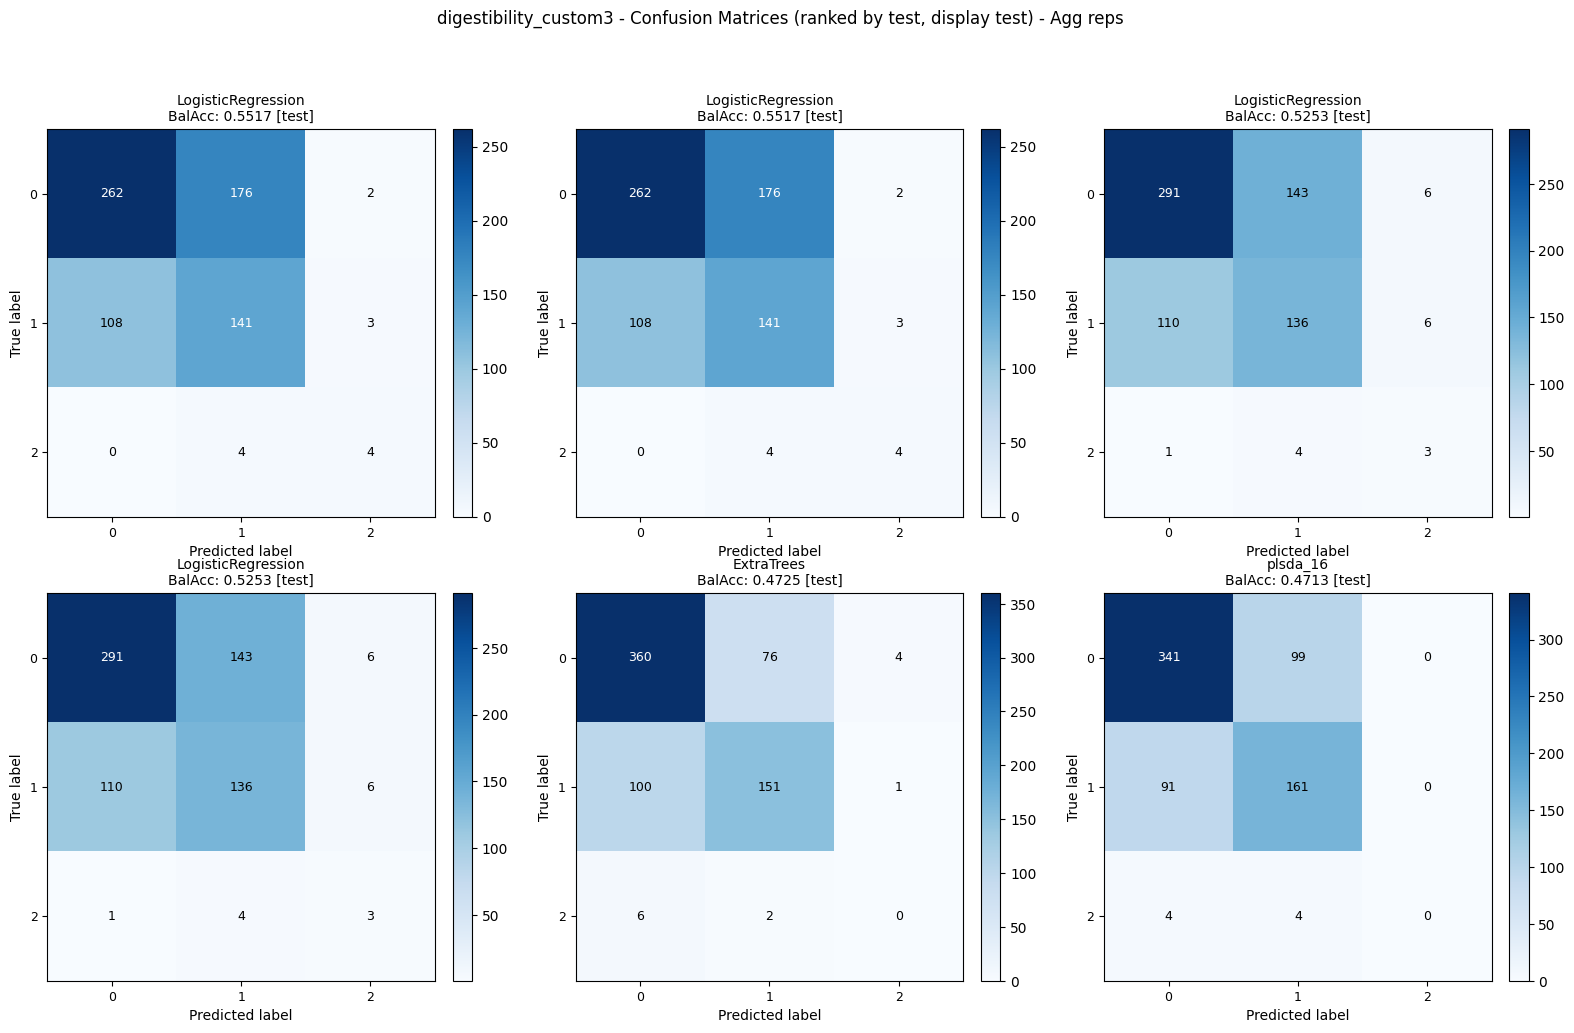

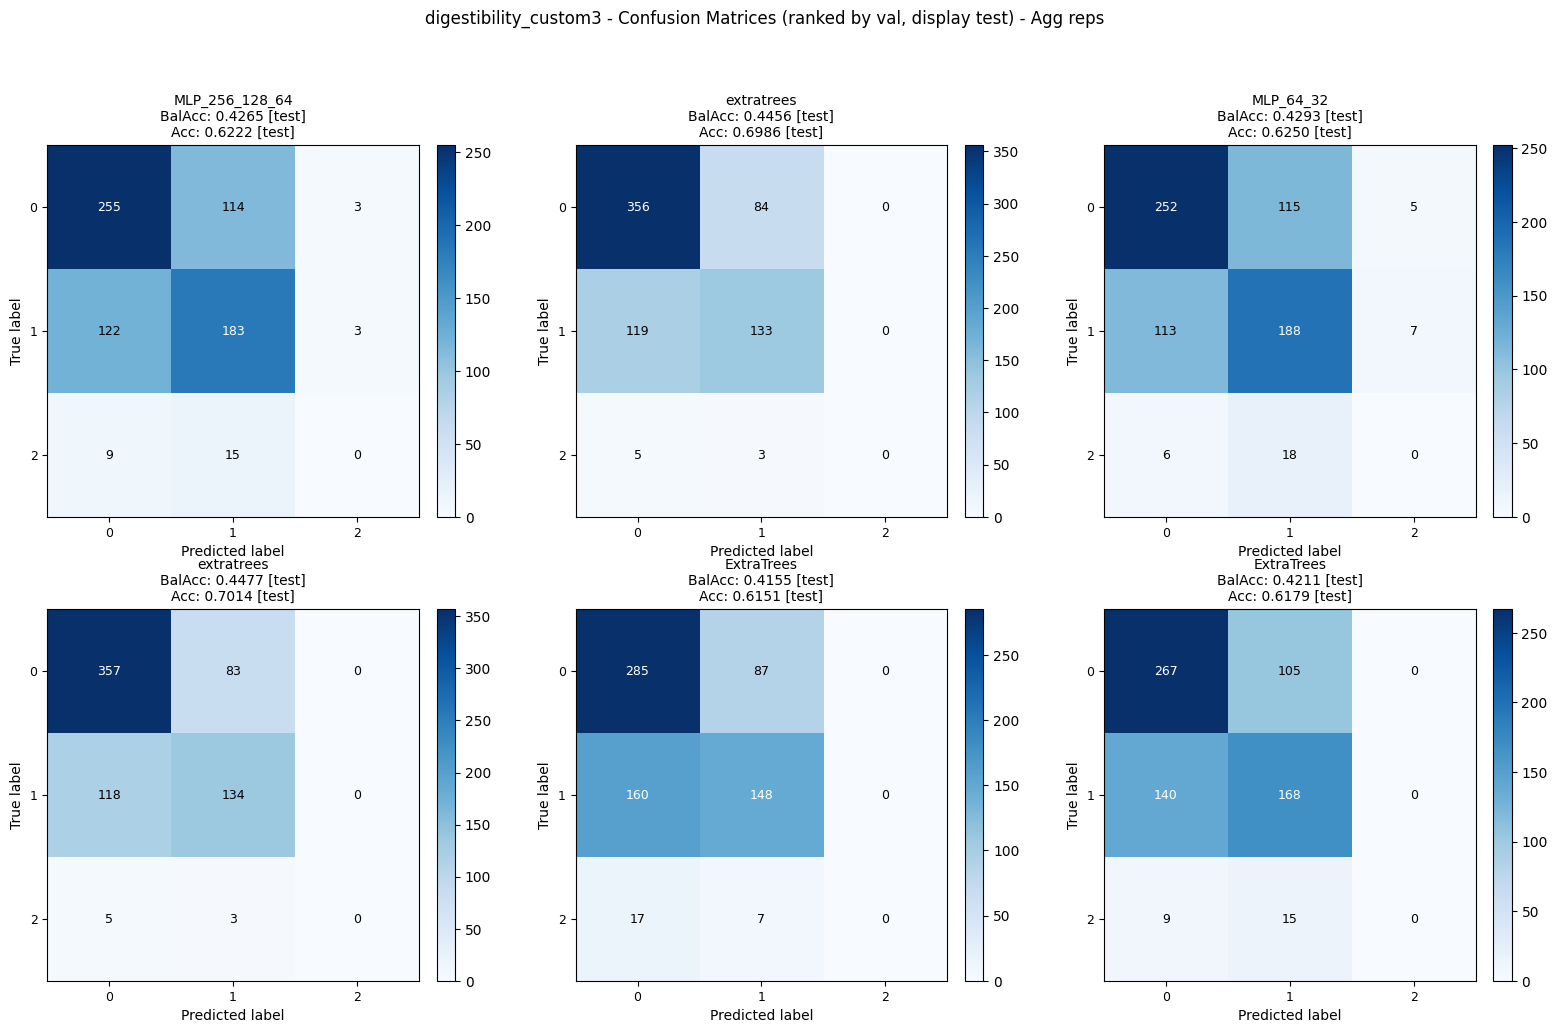

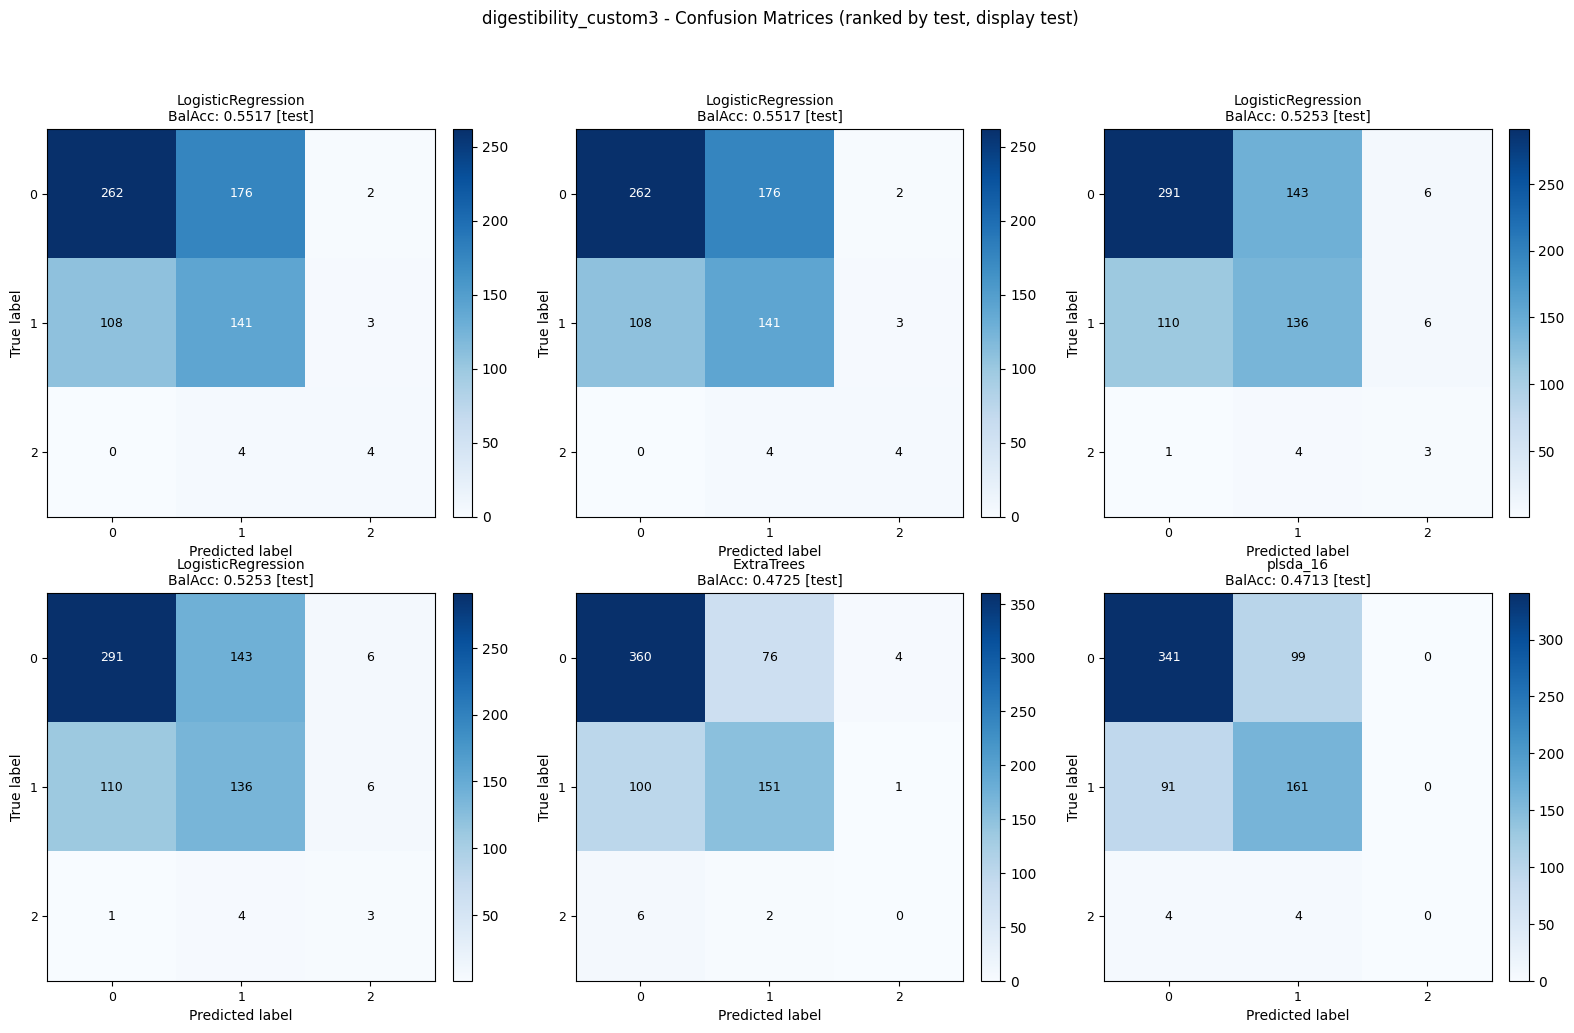

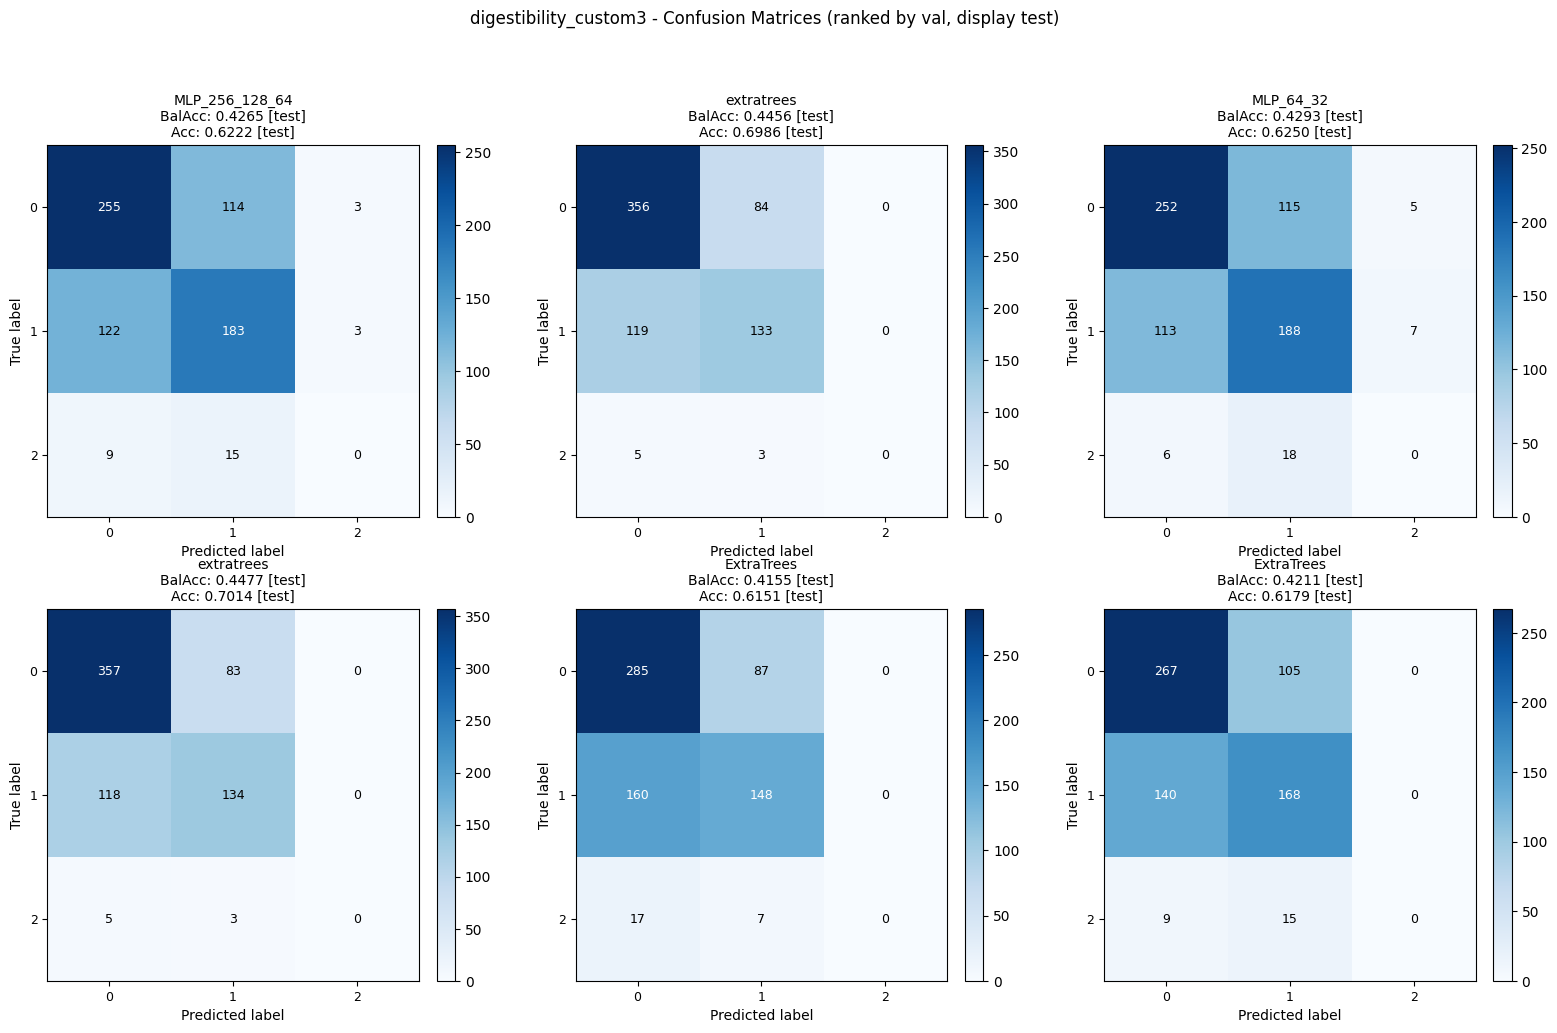


  Heatmap (ranked by val):
Data wrangling time: 0.0271 seconds
Matplotlib render time: 0.1305 seconds


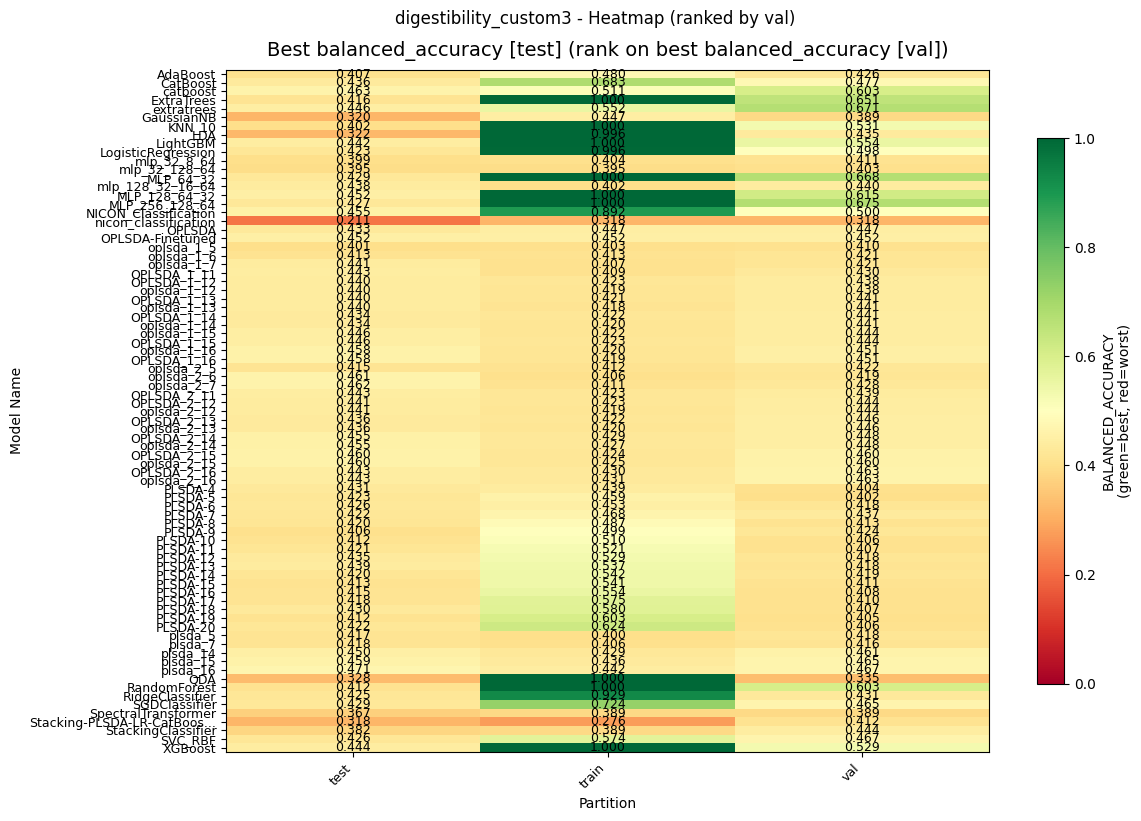


  Heatmap (ranked by test):
Data wrangling time: 0.0140 seconds
Matplotlib render time: 0.1347 seconds


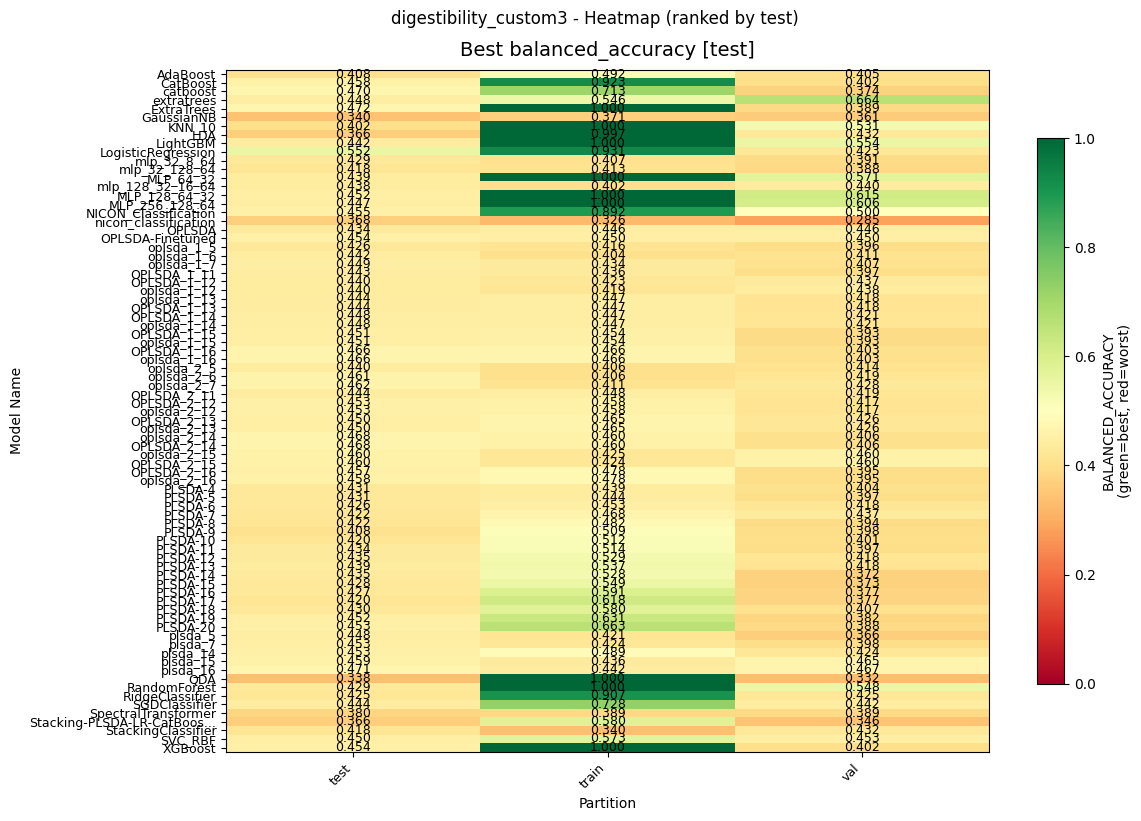


  Heatmap (ranked by val):
Data wrangling time (with aggregation): 5.4232 seconds
Matplotlib render time: 0.0950 seconds


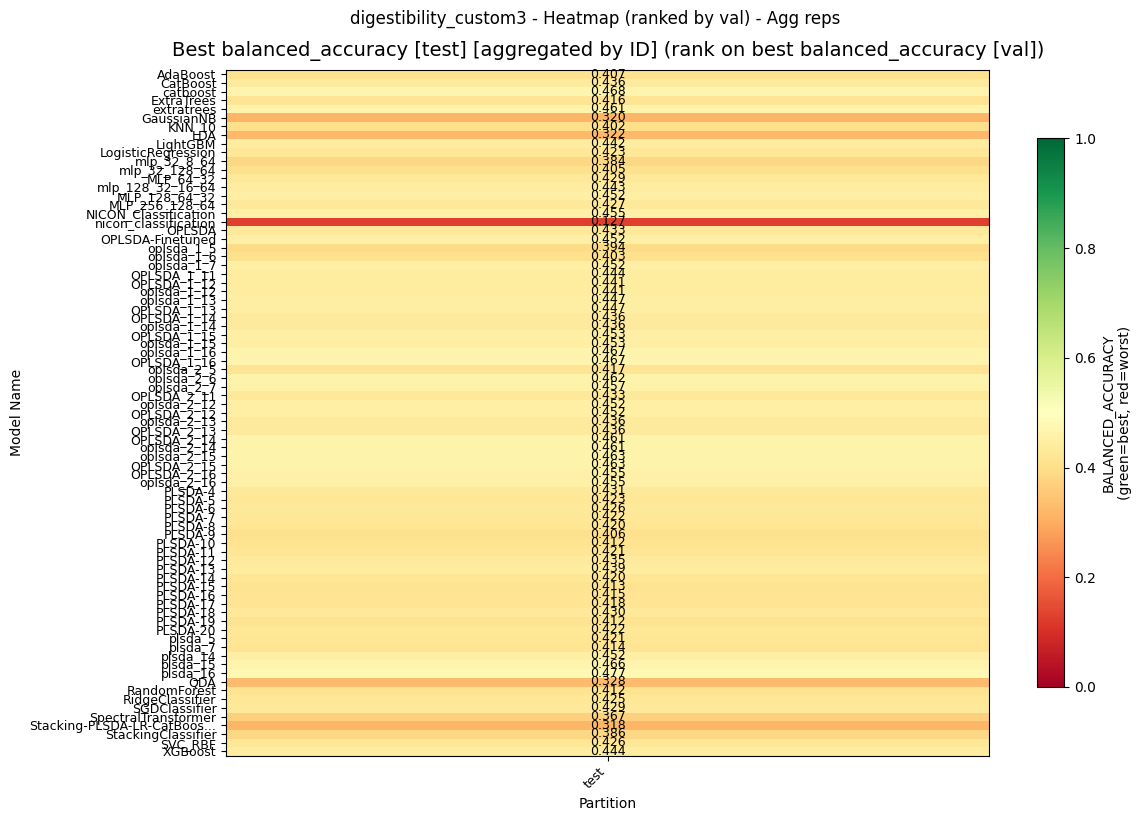


  Heatmap (ranked by test):
Data wrangling time (with aggregation): 5.1940 seconds
Matplotlib render time: 0.0962 seconds


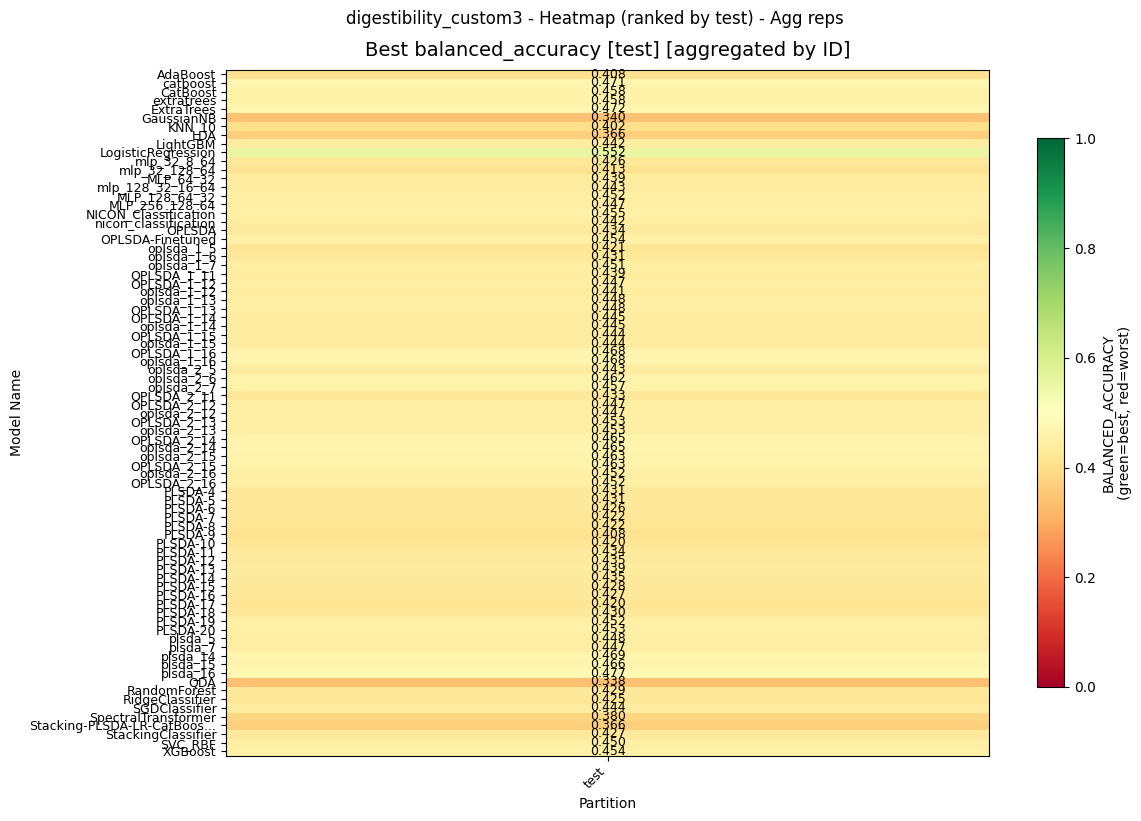

Candlestick data wrangling time: 0.0030 seconds
Matplotlib render time: 0.3252 seconds


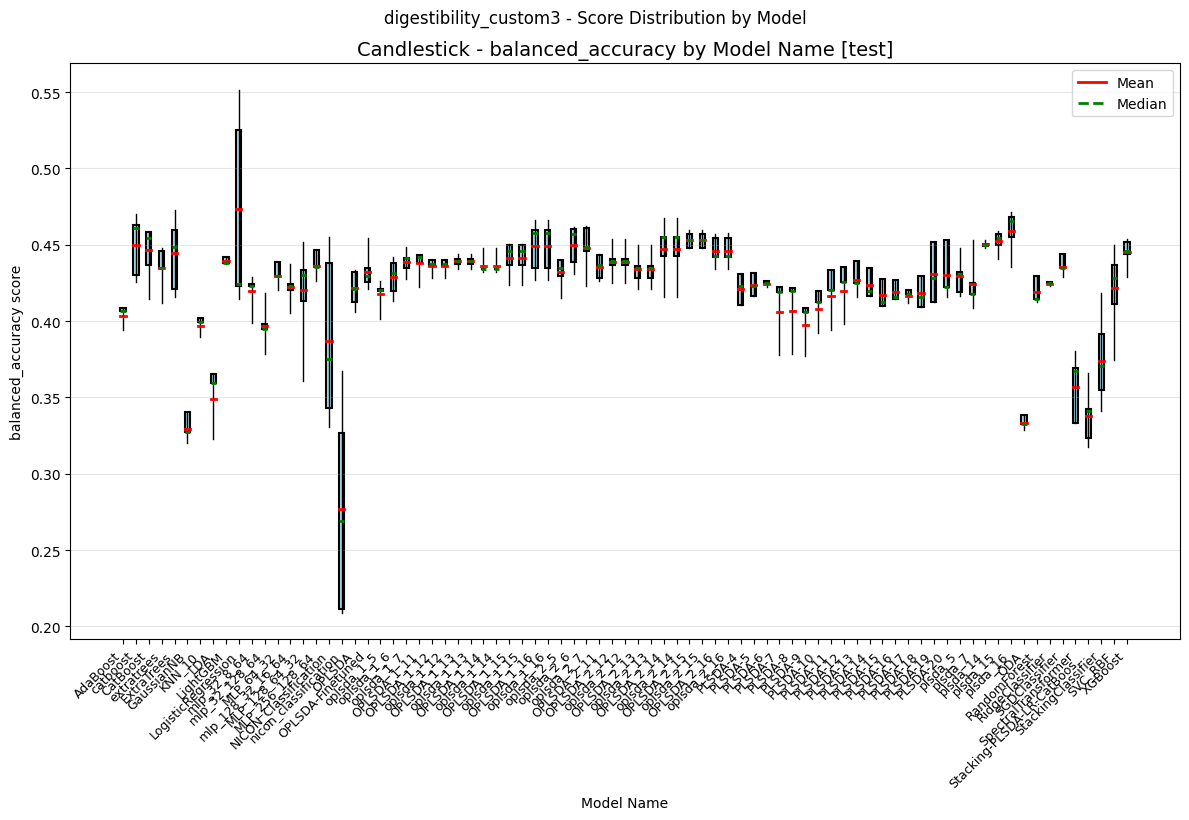

Candlestick data wrangling time: 0.0120 seconds
Matplotlib render time: 0.1565 seconds


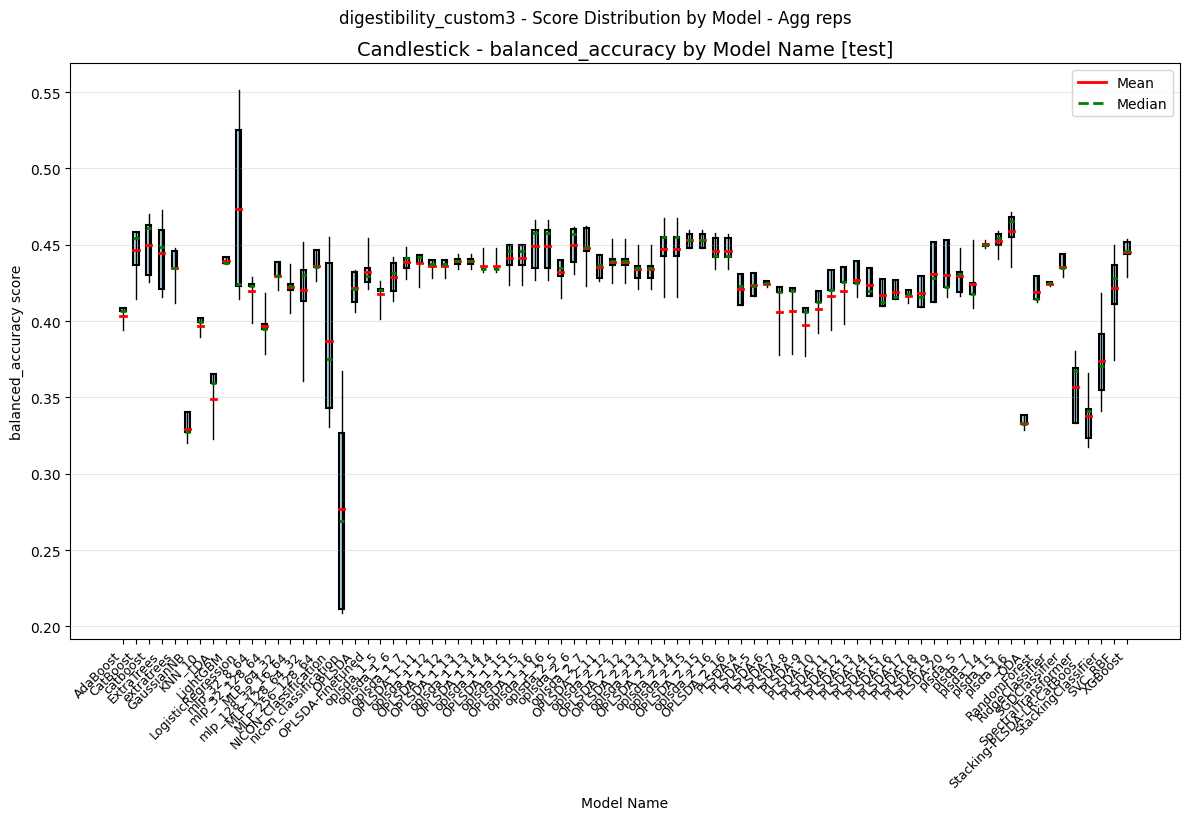

Histogram data wrangling time: 0.0020 seconds
Matplotlib render time: 0.0318 seconds


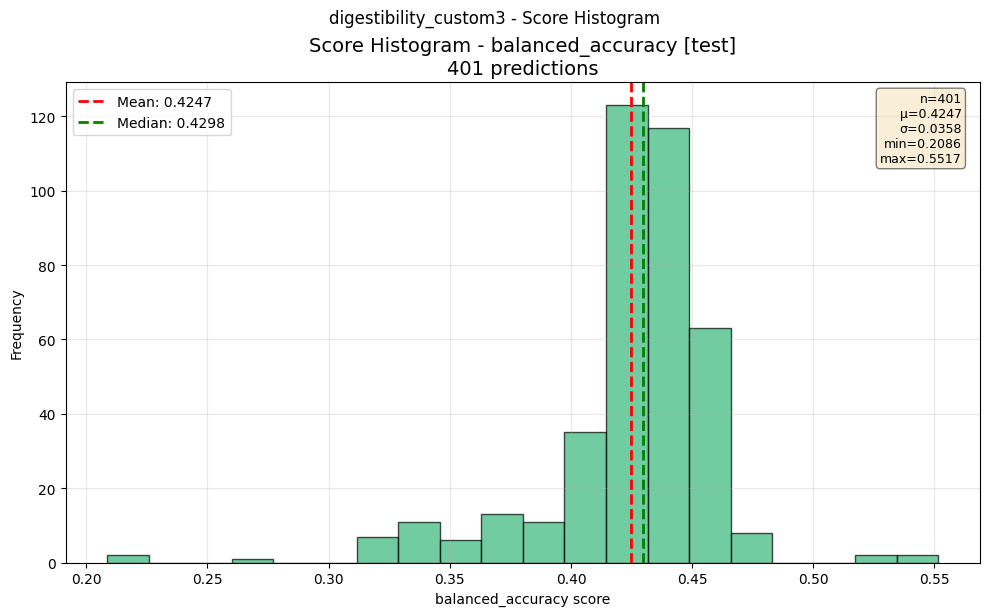

Histogram data wrangling time: 0.0000 seconds
Matplotlib render time: 0.0490 seconds


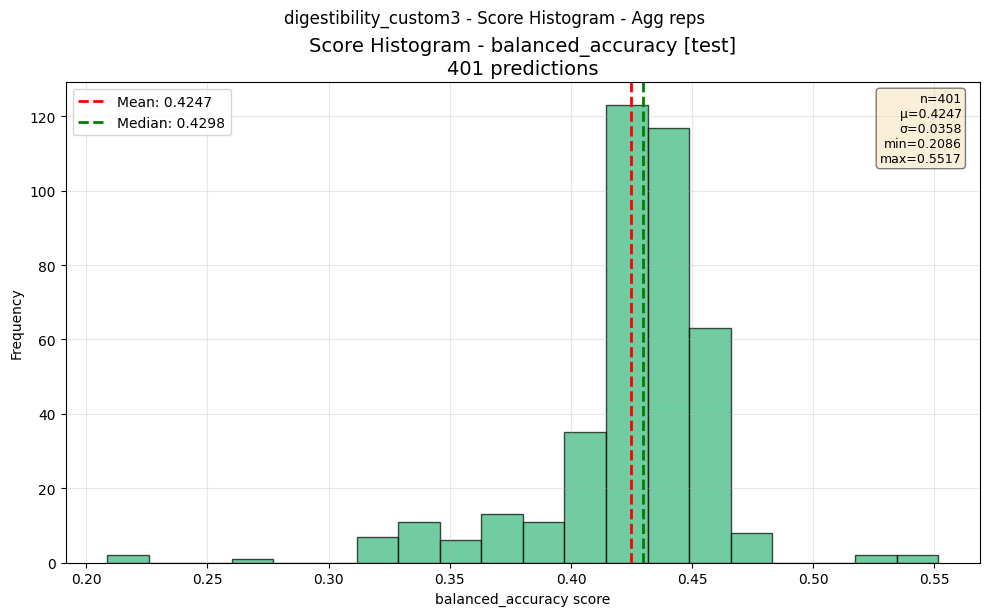


 Analyzing: digestibility_custom5

 Summary Statistics:
    Number of predictions: 3873
    Models: 93 unique (OPLSDA_1_15, SGDClassifier, oplsda_2_16, StackingClassifier, PLSDA-13...)
    Datasets: ['digestibility_custom5']
    Partitions: ['val', 'train', 'test']
    Configs: 31 unique
    Folds: ['2', '1', 'w_avg', 'avg', '0']
    Task type: multiclass_classification

 Top 5 models by balanced_accuracy (val):
   1. extratrees - balanced_accuracy [test: 0.3447], [val: 0.8361],  [val]: [accuracy:0.3771], [balanced_accuracy:0.3447], [f1:0.3718] [test]: [accuracy:0.3771], [balanced_accuracy:0.3447], [f1:0.3718], (fold: avg, id: 4, step: 31) - [2acda0f1ad41438d]
   2. extratrees - balanced_accuracy [test: 0.3495], [val: 0.8292],  [val]: [accuracy:0.3829], [balanced_accuracy:0.3495], [f1:0.3767] [test]: [accuracy:0.3829], [balanced_accuracy:0.3495], [f1:0.3767], (fold: w_avg, id: 5, step: 31) - [d0fc28cb2df5bcc9]
   3. ExtraTrees - balanced_accuracy [test: 0.3303], [val: 0.7395],  [val]:

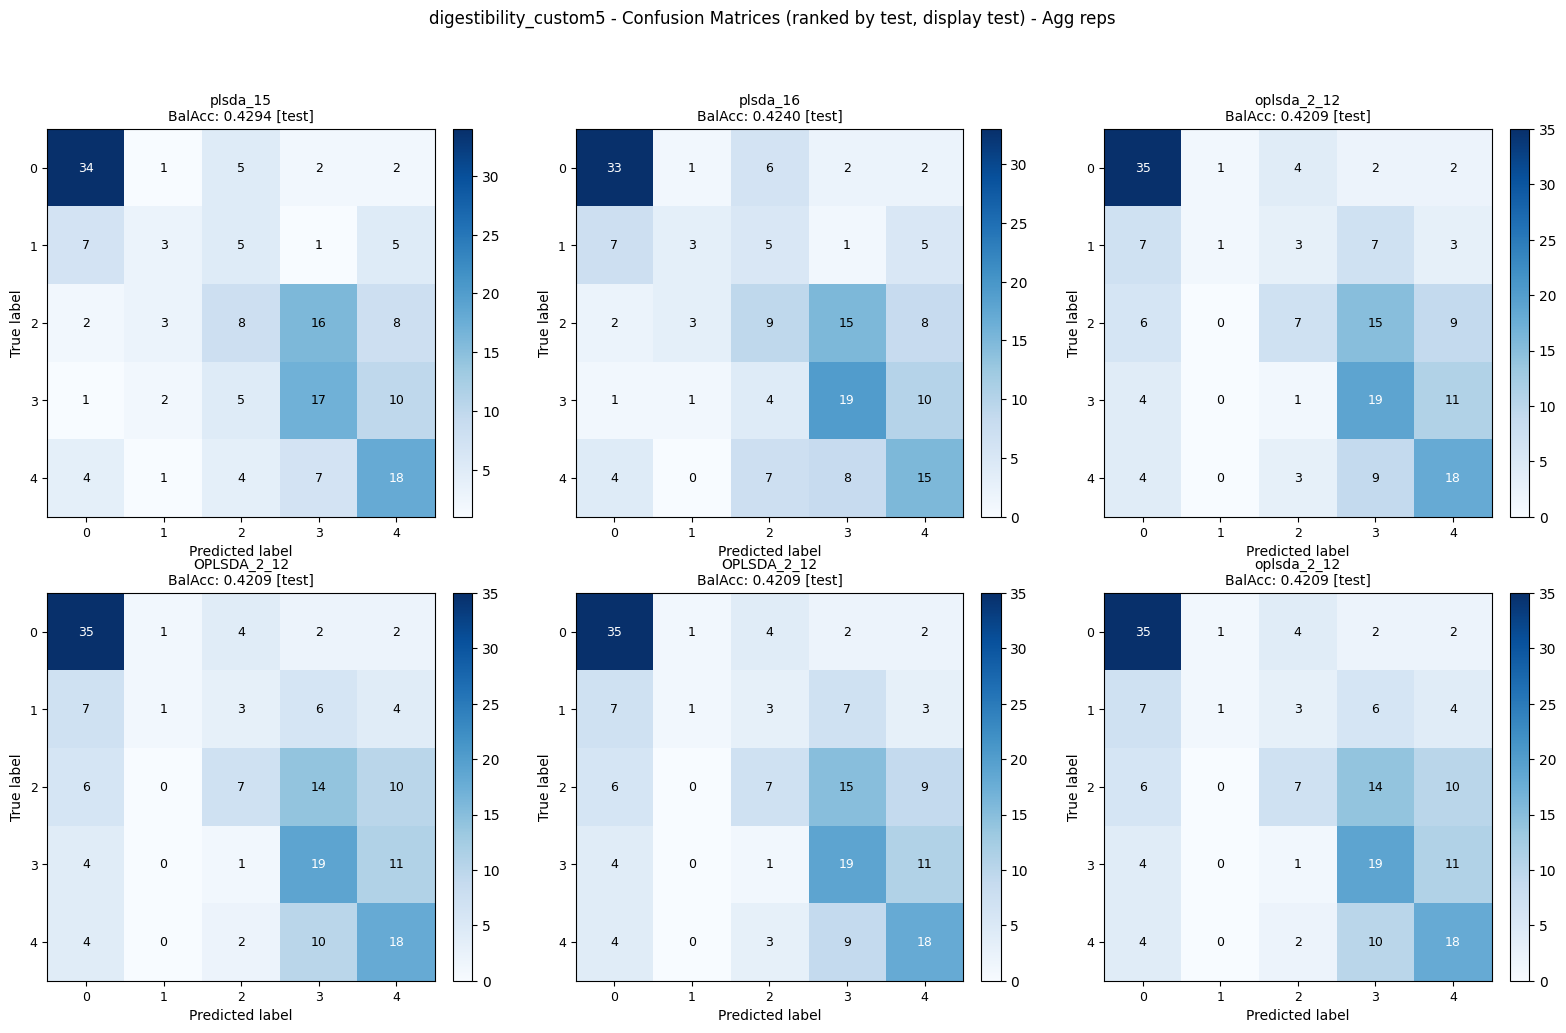

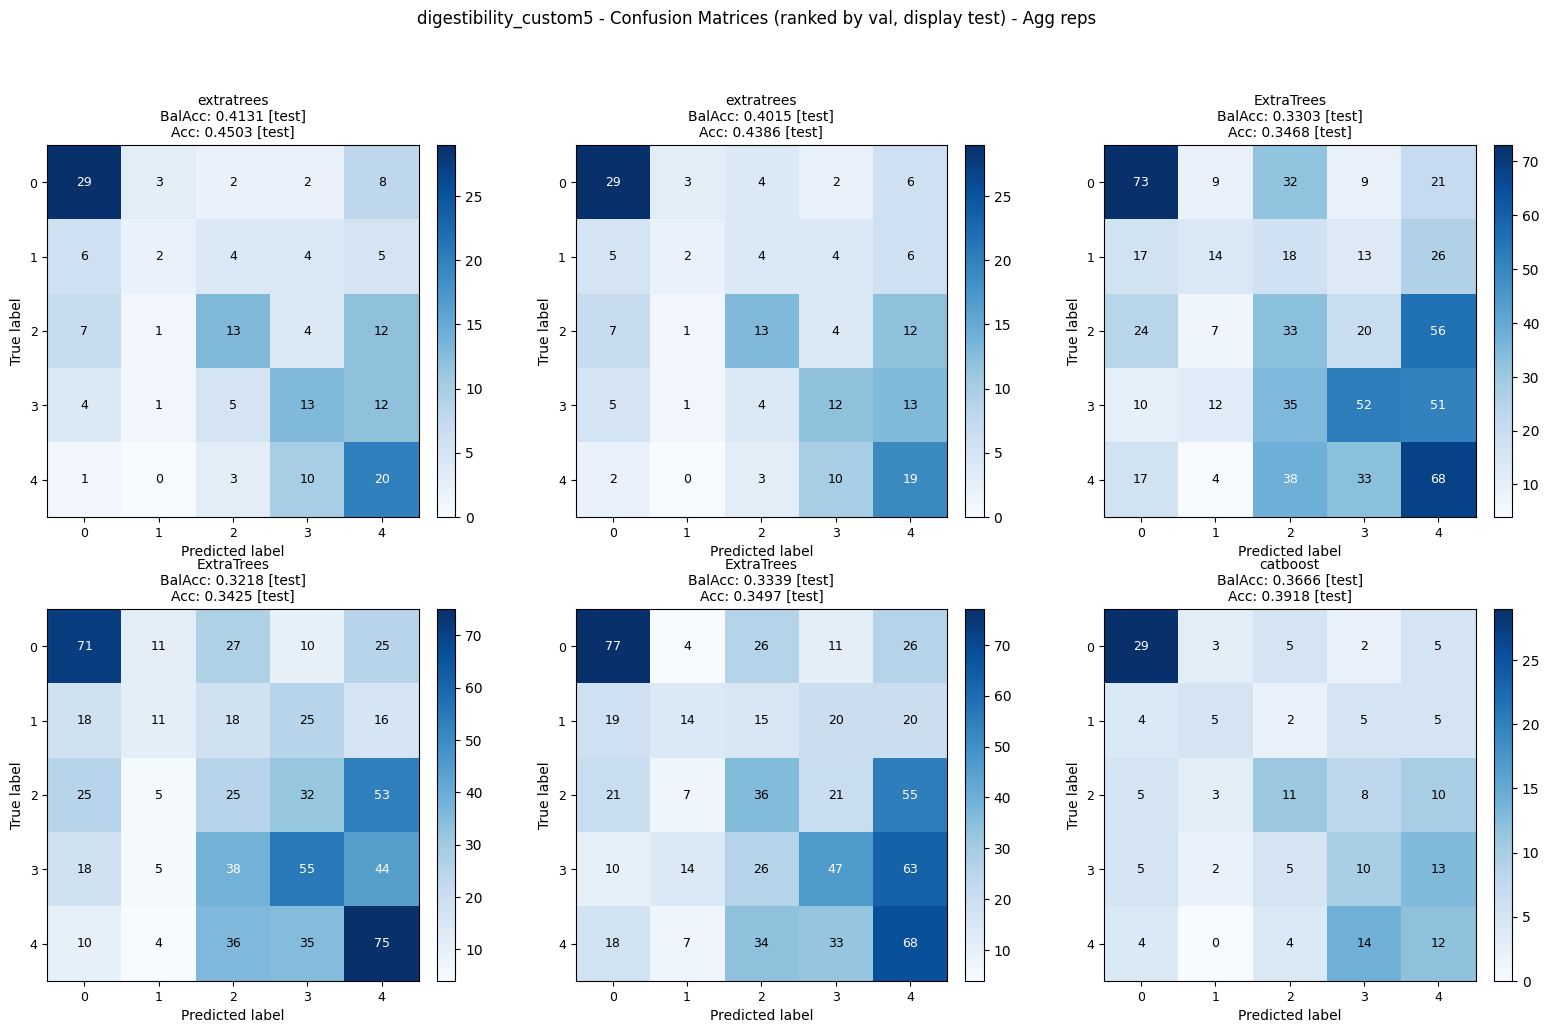

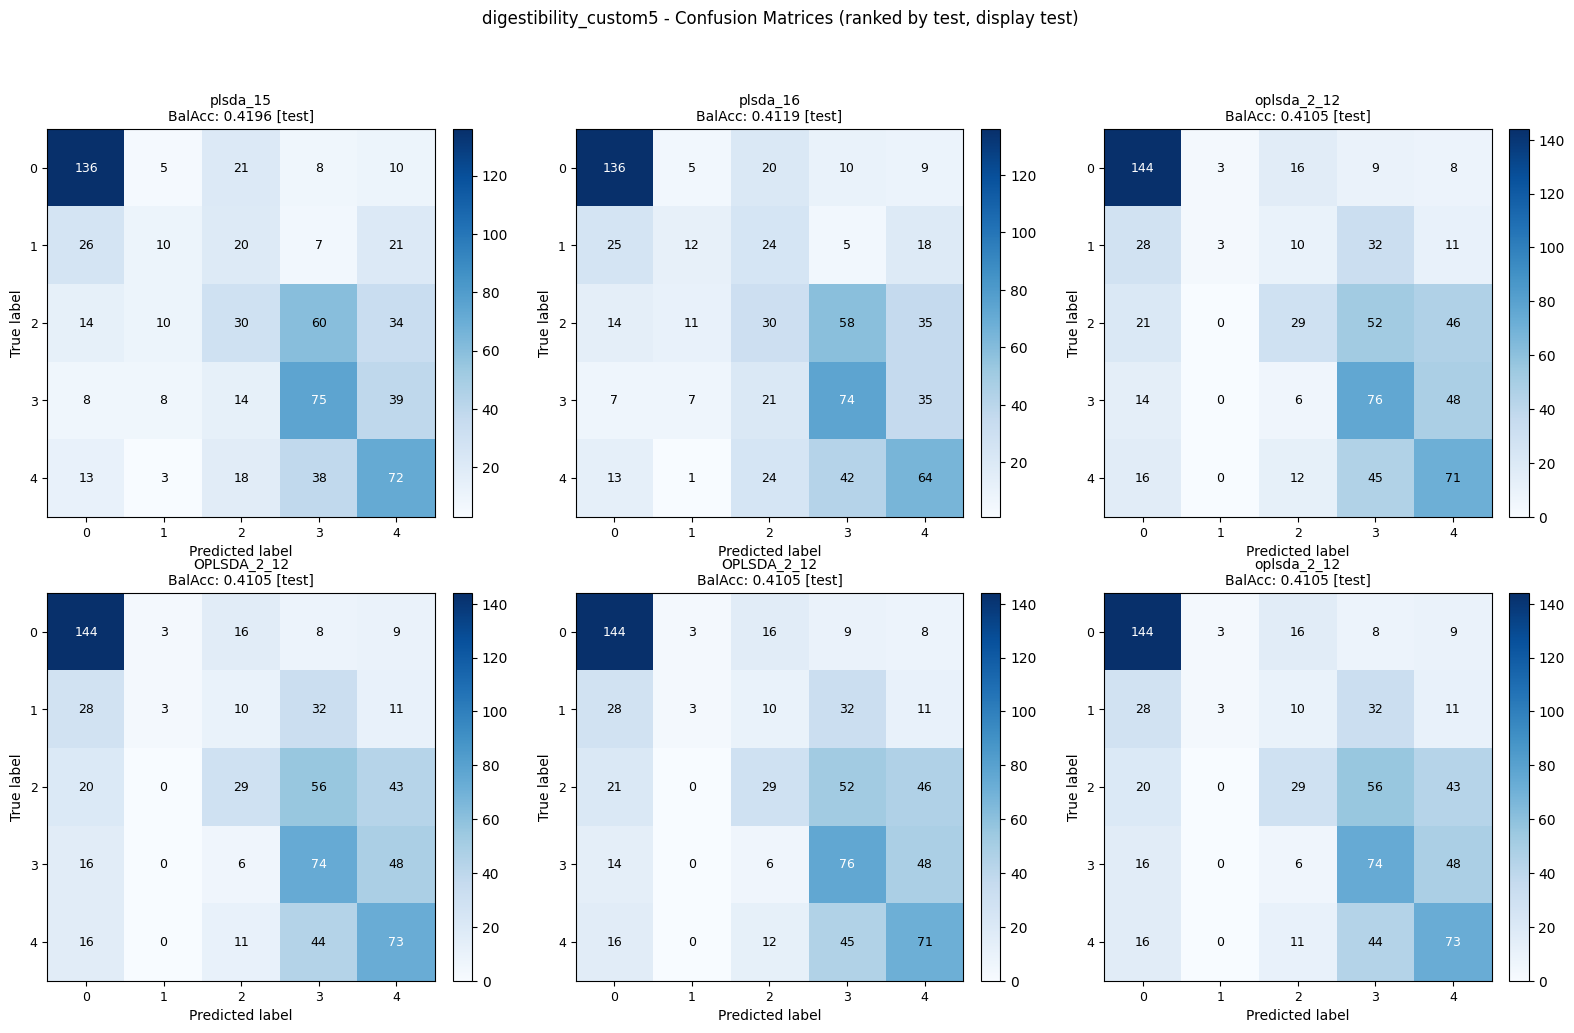

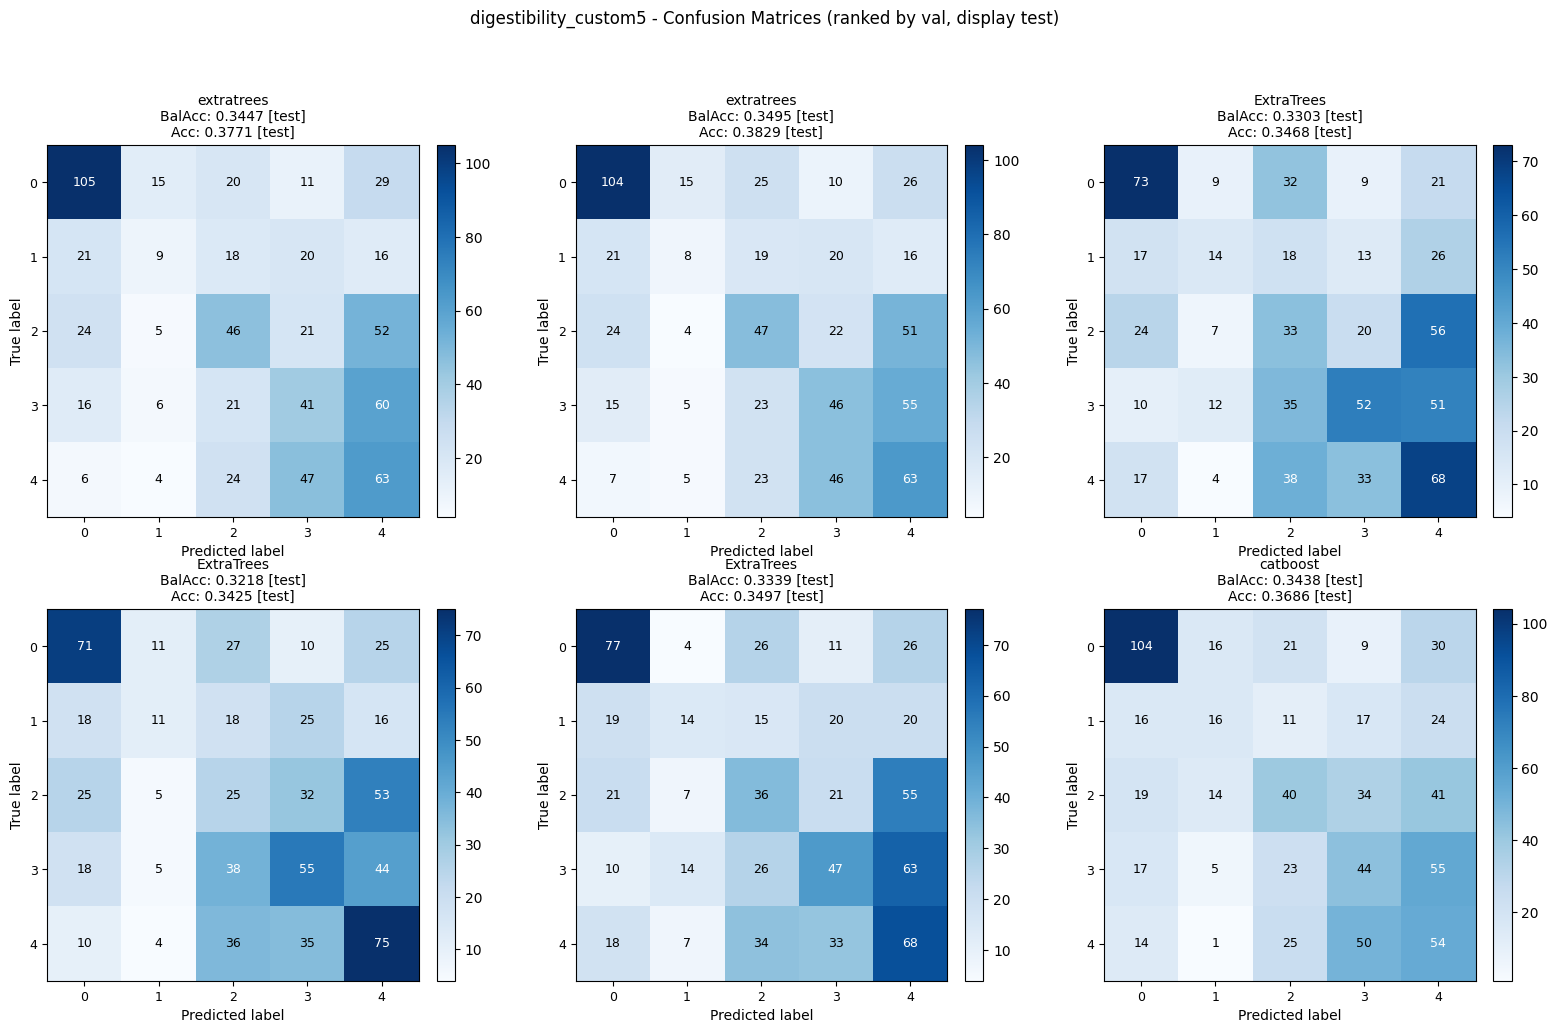


  Heatmap (ranked by val):
Data wrangling time: 0.0472 seconds
Matplotlib render time: 0.1501 seconds


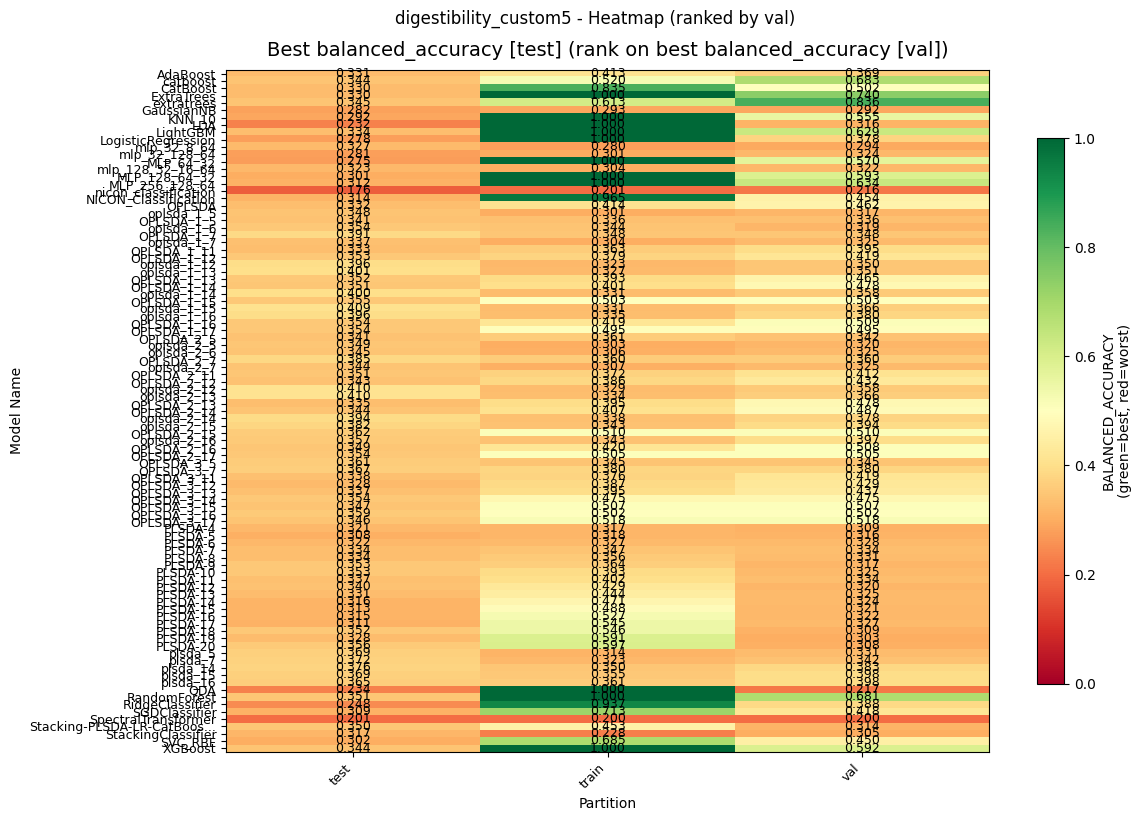


  Heatmap (ranked by test):
Data wrangling time: 0.0423 seconds
Matplotlib render time: 0.1477 seconds


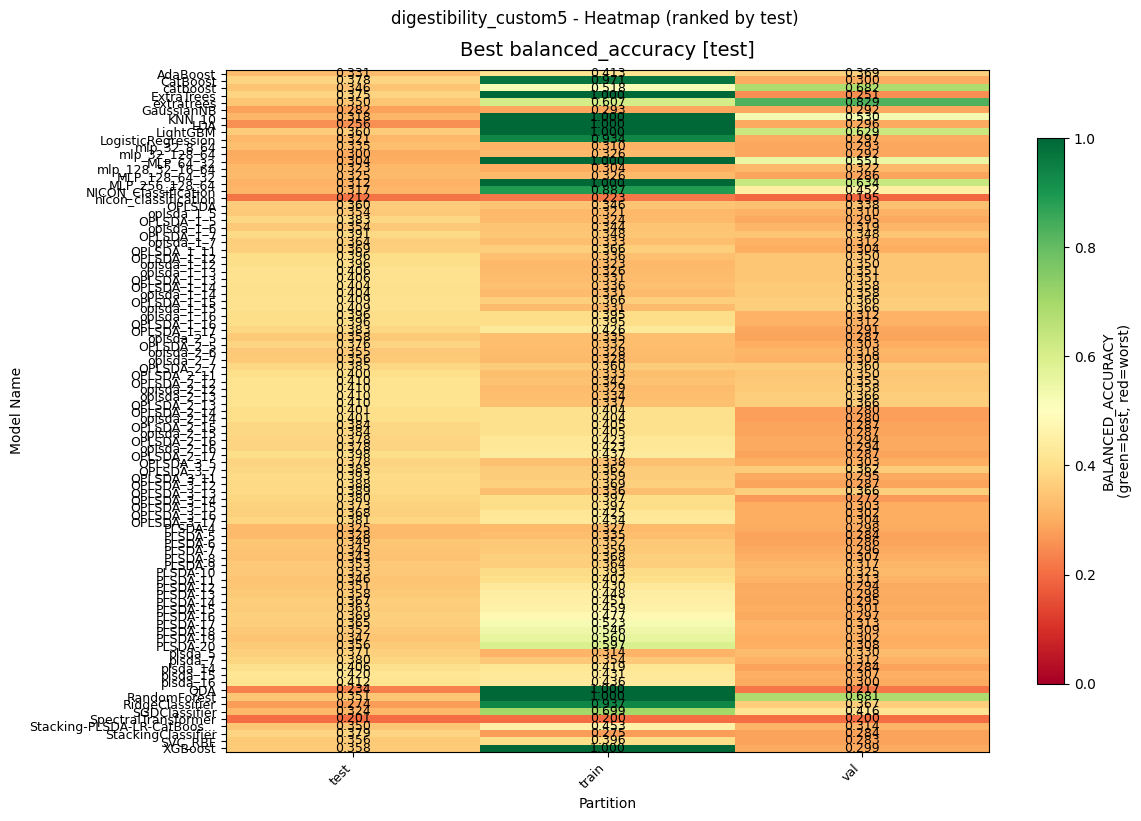


  Heatmap (ranked by val):


KeyboardInterrupt: 

In [9]:
# Process all parquet files
results = {}

for filename in filenames:
    predictions_path = f"{WORKSPACE_PATH}/{filename}.meta.parquet"
    result = analyze_predictions_file(predictions_path)
    if result is not None:
        results[filename] = result


print(f"\n{'='*80}")
print(f"✅ Analysis complete! Processed {len(results)}/{len(filenames)} files.")
print(f"{'='*80}")